# **Start**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title  { display-mode: "form" }
#@title  { display-mode: "form" }
#@title  { vertical-output: true, display-mode: "form" }
#@markdown Select The Best

use_pearson_corr = False #@param ["True", "False"]
Data_to_use = "6_bands" #@param ["6_bands", "65_bands", "372_bands", "Planet_hisar", "Pavia", "Indian_Pines", "Hisar_sentinel"]
use_pearson_corr = True if use_pearson_corr in [True, "True"] else False
method = " with_cls_tkn" #@param [" with_gap", " without_gap", " with_cls_tkn"]
P_S = "9"  #@param [3, 9, 15, 21]
P_S = int(P_S)
patch_size = 3
transformer_layers = 5  #@param [3,5,7,9,11]
projection_dim = 256    #@param [64, 128, 256, 512, 1024]
Targeted_accuracy = "0.985" #@param [0.97, 0.98, 0.985, 0.99, 0.995]
Min_trainable_epoch = 20 #@param [20, 25, 30, 35, 40, 50, 100]

train_percent = 75                  #@param [75, 80, 90]
epoch = "100" # @param ["100","200","300","400","500"]

LR_START = 3e-3
LR_MAX = 6e-3
LR_MIN = 1e-5

batch_size = 128
BATCH_SIZE = 128
dropout_rate_for_uncertainty = "0.25"    #@param [0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
dropout = "0.1"                         #@param [0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
num_patches = (P_S//patch_size)**2

epoch = int(epoch)
Min_trainable_epoch = int(Min_trainable_epoch)
Targeted_accuracy = float(Targeted_accuracy)
train_percent = int(train_percent)
dropout = float(dropout)
dropout_rate = float(dropout_rate_for_uncertainty)
shifts = int(1/dropout_rate)
assert epoch >= Min_trainable_epoch/dropout_rate, f"For Min_trainable_epoch: {Min_trainable_epoch} & dropout_rate: {dropout_rate}, minimum number of `epoch` should be {Min_trainable_epoch/dropout_rate}"
transformer_layers = int(transformer_layers)
projection_dim = int(projection_dim)

print("Number of patches per P_S: ", num_patches)
print("Size of each patch for Multihead Attention: ", patch_size)

Number of patches per P_S:  9
Size of each patch for Multihead Attention:  3


In [ ]:
!pip install spectral
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 9.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow_addons (from versions: none)
ERROR: No matching distribution found for tensorflow_addons


In [ ]:
import pandas as pd           # for csv files and dataframes
import numpy as np            # Linear Algebra tools
import matplotlib.pyplot as plt  # for ploting graphs and curve
from matplotlib import colors, cm, gridspec
import scipy.stats as st
import scipy.io as si         # for inputing matlab files
from random import shuffle    # for shuffling dataset
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix   #Confusion matrix creation
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report

import datetime
import time
import warnings
import math
import os
import gc

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.python.util.tf_export import keras_export
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, Add, Multiply, Reshape, Dense, Activation, BatchNormalization, Flatten, Dropout, concatenate, Lambda, LayerNormalization
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D,  GlobalAveragePooling2D, GlobalAvgPool2D, DepthwiseConv2D, SeparableConv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, add, multiply, MultiHeadAttention
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.utils import control_flow_util
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import glorot_uniform, Ones
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2

import spectral

np.random.seed(1337)          # to get reproducible results
base_path = "/content/drive/MyDrive/m_p/Uncertainty in Models/Vision Transformers/ViT with U-Net architecture/"

try:
    os.mkdir(base_path)
except:
    pass

try:
    os.mkdir(base_path + "With Pearson correlation/") if use_pearson_corr else os.mkdir(base_path + "Without Pearson correlation/")
except:
    pass

if use_pearson_corr:
    folder_path = base_path + "With Pearson correlation/" + str(Data_to_use) + "/"
    try:
        os.mkdir(folder_path)
    except:
        pass
else:
    folder_path = base_path + "Without Pearson correlation/" + str(Data_to_use) + "/"
    try:
        os.mkdir(folder_path)
    except:
        pass

In [ ]:
try:
    os.mkdir(folder_path + "Trained models")
    os.mkdir(folder_path + "Results")
except:
    pass

In [ ]:
Normalize_data = True
if Data_to_use == "6_bands":
    H, W, B = 330, 307, 6
    x = np.array(pd.read_csv('/content/drive/My Drive/m_p/data/multispectral/data.csv'))
    y = np.array(pd.read_csv('/content/drive/My Drive/m_p/data/multispectral/ref.csv'))

if Data_to_use == "65_bands":
    H, W, B = 512, 512, 65
    x = si.loadmat('/content/drive/My Drive/m_p/data/Dias/DIAS.mat')['DIAS']
    y = si.loadmat('/content/drive/My Drive/m_p/data/Dias/DIAS_ref.mat')['DIAS_ref']

if Data_to_use == "372_bands":
    H, W, B = 1101, 566, 372
    x = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full.mat')['full']
    y = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full_gt.mat')['full_gt']
    x[x < 0.0] = 0.0
    x[x > 1.0] = 1.0
    Normalize_data = False
    #x = x[:, selective_bands]

if Data_to_use == "Planet_hisar":
    H, W, B = 1733, 2647, 4
    x = pd.read_csv('/content/drive/My Drive/m_p/data/planet_data_hisar/planet.csv', header=None)
    y = pd.read_csv('/content/drive/My Drive/m_p/data/planet_data_hisar/planetgt.csv', header=None)

if Data_to_use == "Pavia":
    H, W, B = 610, 340, 103
    x = si.loadmat('/content/drive/MyDrive/m_p/data/pavia/paviauni.mat')['paviaU']
    y = si.loadmat('/content/drive/MyDrive/m_p/data/pavia/paviauni_gt.mat')['paviaU_gt']

if Data_to_use == "Indian_Pines":
    H, W, B = 145, 145, 220
    x = si.loadmat('/content/drive/My Drive/m_p/data/Indian_pines/Indian_pines.mat')['indian_pines']
    y = si.loadmat('/content/drive/My Drive/m_p/data/Indian_pines/Indian_pines_gt.mat')['indian_pines_gt']

if Data_to_use == "Hisar_sentinel":
    H, W, B = 722, 1014, 4
    x = np.array(si.loadmat('/content/drive/My Drive/m_p/data/Hissar_25%/datas.mat')['datas'])
    y = np.array(pd.read_csv('/content/drive/My Drive/m_p/data/Hissar_25%/fullgt.csv'))

y_shape = np.array(y).shape[0]
x, y = np.array(x).reshape(H,W,B), np.array(y).reshape(H,W)
x = x.astype('float16')
#########
print("minimum value in raw data is :", x.min())
print("maximum value in raw data is :", x.max(), "\n")
print("shape of raw data: ", x.shape)
print("shape of target data: ", y.shape, "\n")

# Normalizing the data between 0,1
if Normalize_data:
    for i in range(B):
        band_min = x[:,:,i].min()
        band_max = x[:,:,i].max()
        band_range = band_max - band_min
        x[:,:,i] = (x[:,:,i] - band_min)/band_range

minimum value in raw data is : 12.0
maximum value in raw data is : 209.0 

shape of raw data:  (330, 307, 6)
shape of target data:  (330, 307) 



# **Data**

In [ ]:
pad_width = int((P_S-1)/2)
padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')
# np.save("/content/drive/MyDrive/Personal Folder for training/padded_x.npy" , padded_x)
X,Y = [],[]
for a in range(H):
  for b in range(W):
    if(y[a][b]!= 0):
      patch = padded_x[a:a+P_S,b:b+P_S,:]
      X.append(patch)
      Y.append(y[a][b]-1)

num_classes = len(np.unique(y))-1
Approximate_rgb_img = x[:,:,[B//2-1, B//2, B//2+1]]*255

print()
print("minimum value in x is :", x.min())
print("maximum value in x is :", x.max())
print()
print("shape of x: ", x.shape)
print("shape of y: ", y.shape)
print()
print("shape of padded_x: ", padded_x.shape, "\n")
print(f"{len(Y)*100/y_shape:.4f}% of data is labeled with {num_classes} classes")


minimum value in x is : 0.0
maximum value in x is : 1.0

shape of x:  (330, 307, 6)
shape of y:  (330, 307)

shape of padded_x:  (338, 315, 6) 

17.0161% of data is labeled with 7 classes


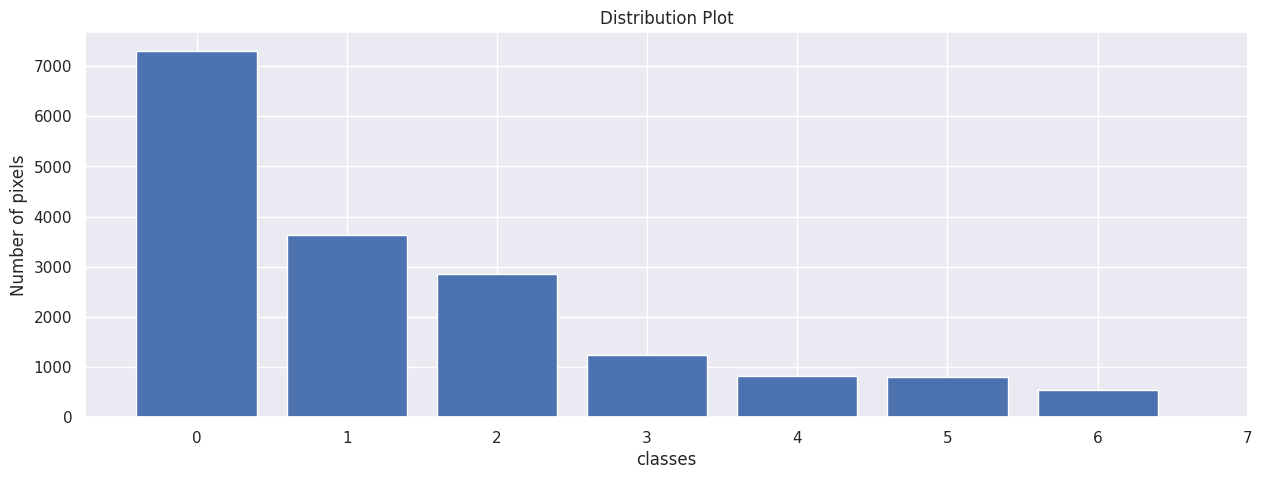

In [ ]:
class_labels, value_counts = np.unique(y.reshape(-1,1), return_counts = True)
plt.figure(figsize = (15,5))
plt.bar(class_labels[1:]-1, value_counts[1:])
plt.xticks(class_labels, rotation = 0)
plt.xlabel("classes")
plt.ylabel("Number of pixels")
plt.title("Distribution Plot")
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=(train_percent/100),stratify=Y, random_state=10)
x_train,x_test,y_train,y_test = np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)
print(f"x_train: {x_train.shape} \nx_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}")

x_train: (12929, 9, 9, 6) 
x_test: (4310, 9, 9, 6) 
y_train: (12929,) 
y_test: (4310,)


# **Functions**

In [ ]:
def predict_half_image_prob(model, padded_x, H, W_range, B, P_S):
    y_prob = np.zeros((H, W_range, num_classes))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i,:,:,:] = padded_x[i:i+P_S, j:j+P_S, :]
        y_pred_prob = model.predict(patchs, verbose = -1)
        y_prob[:,j,:] = y_pred_prob
        del patchs, y_pred_prob
        gc.collect()
    return y_prob

def probabilistic_outputs(model, padded_x, H, W, B, P_S):
    start_time = time.time()
    half_1 = padded_x.shape[1]//2 + pad_width+1
    half_2 = padded_x.shape[1]//2 - pad_width-1
    padded_x_1st_half = padded_x[:,:half_1, :]
    padded_x_2nd_half = padded_x[:,half_2:, :]
    del padded_x
    gc.collect()

    y_hat = np.zeros((H,W, num_classes))
    y_hat[:,:W//2,:] = predict_half_image_prob(model, padded_x_1st_half, H, W//2, B, P_S)
    print("image predicted ███████████████████████ 50%")
    gc.collect()
    width = W//2 if W//2 == W/2 else W//2+1
    y_hat[:,W//2:,:] = predict_half_image_prob(model, padded_x_2nd_half, H, width, B, P_S)
    print("image predicted ██████████████████████████████████████████████ 100%")
    gc.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_min = time_taken//60
    time_sec = time_taken - time_min*60
    print(f'total time taken is: {time_min} min {time_sec:.2f} sec.')
    print("shape of predicted image is: ", y_hat.shape)
    return y_hat

In [ ]:
def predict(model, x_test):
    y_pred = np.argmax(model.predict(x_test, verbose = -1), axis = -1)
    return y_pred

In [ ]:
def plot_accuracy_loss_curve(history, use_pearson_corr = None, folder_path = None):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize = (24,8))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(train_accuracy, color='blue', marker='o', linewidth=1.5, markersize = 2,  label = 'train_accuracy')
    ax.plot(val_accuracy, color='green', marker='o', linewidth=1.5, markersize = 2, label = 'val_accuracy')
    ax.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(train_loss, color = 'black', marker='o', linewidth=1.5, markersize = 2, label = 'train_loss')
    ax2.plot(val_loss, color = 'red', marker='o', linewidth=1.5, markersize = 2, label = 'val_loss')
    ax2.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance')
    ax2.legend()
    plt.show()
    if folder_path:
        if use_pearson_corr:
            path = folder_path + "Results/Pearson_Corr " + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        else:
            path = folder_path + "Results/" + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        fig.savefig(path)

In [ ]:
def performance_meausures(y_test, y_pred, tt, *parameters_summary, folder_path = None):
    Total_params, Trainable_params, Non_trainable_params = parameters_summary
    accuracy = accuracy_score(y_test, y_pred)
    kappa=cohen_kappa_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred).astype('int32')
    cr = classification_report(y_test, y_pred, output_dict=True)
    df_cr = pd.DataFrame(cr).T
    df_score = pd.DataFrame({'accuracy score: ' : [accuracy], 'Cohen_Kappa score: ' : [kappa], "Training Time: " : [tt]}).T
    df_summary = pd.DataFrame({'Total_params: ': [Total_params], 'Trainable_params: ' : [Trainable_params], 'Non_trainable_params: ':[Non_trainable_params]}).T

    spec = gridspec.GridSpec(ncols = 2, nrows = 2, width_ratios=[1,3], wspace = 0.5, hspace = 0.5, height_ratios=[7,1])

    fig = plt.figure(figsize = (24,10))

    ax1 = fig.add_subplot(spec[0])
    ax1.set_title('classification report')
    sns.heatmap(df_cr, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax1)

    ax2 = fig.add_subplot(spec[1])
    ax2.set_title('confusion matrix')
    ax2.set_xlabel('predicted class')
    ax2.set_ylabel('actual class')
    sns.heatmap(cm, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax2)

    ax3 = fig.add_subplot(spec[2])
    sns.heatmap(df_score, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax3)
    ax3.set_xticks([])

    ax4 = fig.add_subplot(spec[3])
    sns.heatmap(df_summary, cmap = "Blues", cbar = False, annot = True, fmt=' .10g', ax = ax4)
    ax4.set_xticks([])

    if folder_path:
        path = folder_path + "Results/" + str(train_percent) + "% ps_" + str(P_S) +" Performance Measure.png"
        fig.savefig(path)

In [ ]:
def measure_uncertainty(model, x_test, y_test):
    y_prob = model.predict(x_test, verbose = -1)

    """Sorting is as follow
    y_prob = [[11 12 13 22]
              [31 10 33  7]
              [21  7 23 14]]

    temp_prob will sort the y_prob along rows
    temp_prob = [[11 12 13 22]
                 [7  10 31 33]
                 [7  14 21 23]]

    Now sort the y_prob based on the last column of temp_pred i.e. last col is [22, 33, 23] and sorting will be [22, 23, 33] ---> [0, 2, 1]
     y_prob = [[11 12 13 22]
               [21  7 23 14]
               [31 10 33  7]]
    """
    temp_pred = np.sort(y_prob, axis = -1)      # sort the probabilities along rows. Higher prob values are along last column
    y_prob = y_prob[temp_pred[:,-1].argsort()]  # Arange the rows of predicted prob in assending position

    num = y_prob.shape[0]
    # observed = y_prob.max(axis = -1)
    observed = np.sort(y_prob, axis = -1)[:,-1]    # class predicted according to 1st maximum prob
    observed_1 = np.sort(y_prob, axis = -1)[:,-2]  # class predicted according to 2nd maximum prob
    observed_2 = np.sort(y_prob, axis = -1)[:,-3]  # class predicted according to 3rd maximum prob

    mean = y_prob.mean(axis = -1)
    std = y_prob.std(axis = -1)
    plt.figure(figsize = (24,8))
    plt.plot(np.arange(1, num+1, 1), observed - observed_1, color = "black", label = "certaintity")
    plt.plot(np.arange(1, num+1, 1), observed, color = "blue", label = "observed")
    plt.plot(np.arange(1, num+1, 1), observed_1, color = "purple", label = "observed_1")
    plt.plot(np.arange(1, num+1, 1), observed_2, color = "cyan", label = "observed_2")
    plt.plot(np.arange(1, num+1, 1), mean, color = "red", label = "mean")
    plt.plot(np.arange(1, num+1, 1), mean + 2*std, color = "green", label = "mean + 2*std")
    plt.plot(np.arange(1, num+1, 1), mean - 2*std, color = "green", label = "mean - 2*std")
    plt.legend()
    plt.title("Predictions based on normal model")
    plt.show()

In [ ]:
class Pearson_correlation_masked(layers.Layer):
    def __init__(self, P_S = 9, **kwargs):
        super(Pearson_correlation_masked, self).__init__(**kwargs)
        self.P_S = P_S

    def call(self, inputs):
        self.loc = (self.P_S)//2
        self.inputs = inputs
        self.channels = self.inputs.shape[-1]
        self.x_mean = tf.repeat(tf.math.reduce_mean(self.inputs, axis = -1, keepdims=True), repeats = self.channels, axis = -1)

        self.y = tf.repeat(tf.repeat(self.inputs[:,self.loc:self.loc+1, self.loc:self.loc+1, :], repeats = self.P_S, axis = -2), repeats = self.P_S, axis = -3)

        self.y_mean = tf.repeat(tf.math.reduce_mean(self.y, axis = -1, keepdims = True), repeats = self.channels, axis = -1)

        self.a = tf.math.subtract(self.inputs, self.x_mean)
        self.b = tf.math.subtract(self.y, self.y_mean)
        self.ab = tf.math.multiply(self.a,self.b)
        self.num = tf.math.reduce_sum(self.ab, axis = -1, keepdims = True)

        self.a_new = tf.math.reduce_sum(tf.math.multiply(self.a, self.a), axis = -1, keepdims = True)
        self.b_new = tf.math.reduce_sum(tf.math.multiply(self.b, self.b), axis = -1, keepdims = True)
        self.deno = tf.math.sqrt(tf.math.multiply(self.a_new, self.b_new))

        self.corr = tf.math.divide(self.num, self.deno)

        self.thresh = tf.math.reduce_mean(self.corr)
        self.mask = self.corr > self.thresh
        self.mask = tf.cast(self.mask, self.corr.dtype)

        self.masked_corr = tf.math.multiply(self.mask, self.corr)

        self.attention_weights = tf.repeat(self.masked_corr, repeats = self.channels, axis = -1)
        return multiply([self.inputs, self.attention_weights])

    def get_config(self, **kwargs):
        config = super(Pearson_correlation_masked, self).get_config()
        config.update({
            "P_S": self.P_S,
        })
        return config

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class Dropout_Train(layers.Layer):
    def __init__(self, rate, shift=1, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate
        self.shift = shift

    def call(self, inputs, training=None):
        if self.rate == 0:
            return inputs

        def dropped_inputs():
            input_dim = tf.shape(inputs)[-1]

            range_0 = tf.cast(self.rate * (self.shift - 1) * tf.cast(input_dim, tf.float32), tf.int32)
            range_1 = tf.cast(self.rate * self.shift * tf.cast(input_dim, tf.float32), tf.int32)

            # Build mask dynamically
            mask = tf.concat([
                tf.ones([range_0], dtype=inputs.dtype),
                tf.zeros([range_1 - range_0], dtype=inputs.dtype),
                tf.ones([input_dim - range_1], dtype=inputs.dtype)
            ], axis=0)

            # Reshape mask: broadcast to [batch, seq_len, channels]
            mask = tf.reshape(mask, [1, 1, input_dim])
            return inputs * mask

        return tf.__internal__.smart_cond.smart_cond(
            training,
            true_fn=dropped_inputs,
            false_fn=lambda: tf.identity(inputs),
        )

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
def modified_model(model, layer_name, rate, new_layer, shift, **kwargs):
    name = kwargs.get("name", None)

    x = model.layers[0].output
    modification = False
    z = 0

    for lyr in model.layers[1:]:
        lyr_name = lyr.name.upper()
        target = layer_name.upper()

        if target in lyr_name:
            # When shift is int
            if not isinstance(shift, str):
                x = new_layer(rate=rate, shift=shift, name=f"{layer_name}_{shift}_{z}")(x)
            else:
                # When shift is str
                x = new_layer(rate=rate, name=f"{layer_name}_{shift}_{z}")(x)
            modification = True
            z += 1
        else:
            x = lyr(x)

    if not modification:
        print("⚠️ Warning: No layer was modified. Check if layer_name matches actual model.layer names!")

    return Model(inputs=model.inputs, outputs=x, name=name)

In [ ]:
from tensorflow.keras.callbacks import Callback

class CustomCallbacks(Callback):
    def __init__(self, filepath, epochs, rate,
                 new_layer=Dropout_Train,
                 layer_name="DROPOUT",
                 accuracy_score=0.99,
                 min_epochs=50):
        super().__init__()
        self.filepath = filepath
        self.epochs = epochs
        self.new_layer = new_layer
        self.rate = rate
        self.best = 0.0
        self.epoch_num = 1
        self.layer_name = layer_name
        self.min_epochs = min_epochs
        self.accuracy_score = accuracy_score if accuracy_score <= 1.0 else accuracy_score / 100.0

    def on_train_begin(self, logs=None):
        self.shift = 1
        self.epoch_completed = 0
        print(f"Model will be trained in {int(1/self.rate)} shifts")
        print("Starting training with 1st shift\n")
        self.model = modified_model(self.model, self.layer_name, self.rate, self.new_layer, self.shift)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = None
        # make it robust across tf/keras metric names
        for k, v in logs.items():
            if "val" in k and "acc" in k:
                val_acc = v
                break

        self.epoch_completed += 1
        self.epoch_num += 1

        if val_acc and val_acc >= self.accuracy_score and self.epoch_completed >= self.min_epochs:
            if self.shift < int(1 / self.rate):
                print(f"\nTargeted accuracy reached. Completing shift {self.shift}/{int(1/self.rate)}")
                self.shift += 1
                self.model = modified_model(self.model, self.layer_name, self.rate, self.new_layer, self.shift)
                self.epoch_completed = 0
            elif self.shift == int(1 / self.rate):
                print("\nAll shifting done. Rebuilding final model...")
                self.model = modified_model(self.model, self.layer_name, self.rate, self.new_layer, "Final", name="ResNet")
                self.shift += 1
                self.epoch_completed = 0

        if self.shift >= int(1 / self.rate):
            if val_acc is not None and val_acc > self.best and (self.epoch_num >= self.epochs - 10):
                print(f"val_accuracy improved from {self.best:.4f} to {val_acc:.4f}")
                self.best = val_acc
                self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        if self.shift <= int(1 / self.rate):
            raise RuntimeError(f"Training incomplete: only {self.shift-1} shifts done (expected {int(1/self.rate)})")

        print(f"Training completed in {self.shift-1} shifts.")
        self.model.set_weights(self.best_weights)
        print(f"Saving best model to {self.filepath}")
        self.model.save(self.filepath)

In [ ]:
class SpectralAttention(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.pool = layers.GlobalAveragePooling2D(keepdims=True)
        self.conv1 = layers.Conv2D(filters, kernel_size=1, activation="relu")
        self.conv2 = layers.Conv2D(filters, kernel_size=1, activation="sigmoid")

    def call(self, inputs):
        x = self.pool(inputs)          # [B, 1, 1, C]
        x = self.conv1(x)              # [B, 1, 1, C]
        x = self.conv2(x)              # [B, 1, 1, C]
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.filters})
        return config

In [ ]:
class SpatialAttention(layers.Layer):
    def __init__(self, k_size=3, **kwargs):
        super().__init__(**kwargs)
        self.k_size = k_size
        self.norm = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(1, kernel_size=(k_size, k_size), padding="same")
        self.conv2 = layers.Conv2D(1, kernel_size=(k_size, k_size), padding="same")
        self.conv3 = layers.Conv2D(1, kernel_size=(k_size, k_size), padding="same")
        self.conv4 = layers.Conv2D(1, kernel_size=(k_size, k_size), padding="same")
        self.act_relu = layers.Activation("relu")
        self.act_sigmoid = layers.Activation("sigmoid")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.norm(x)
        x = self.conv2(x)
        x = self.act_relu(x)
        x = self.conv3(x)
        x = self.act_relu(x)
        x = self.conv4(x)
        return self.act_sigmoid(x)

    def get_config(self):
        config = super().get_config()
        config.update({"k_size": self.k_size})
        return config

In [ ]:
class SpatialAttention1(layers.Layer):
    def __init__(self, input_shape, **kwargs):
        super().__init__(**kwargs)
        self.input_shape_val = input_shape
        self.filters = input_shape[-1]
        self.k_size = input_shape[1]

        self.norm = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(self.filters, kernel_size=3, padding="same", kernel_initializer="he_normal")
        self.conv2 = layers.Conv2D(self.filters, kernel_size=3, strides=2, padding="same")
        self.conv3 = layers.Conv2D(self.filters, kernel_size=3, strides=2, padding="same")

        self.convt1 = layers.Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding="same")
        self.convt2 = layers.Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding="same")

        self.relu = layers.ReLU()
        self.sigmoid = layers.Activation("sigmoid")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.norm(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.relu(x)

        x = self.convt1(x)
        x = self.relu(x)

        x = self.convt2(x)
        x = self.relu(x)

        # shape correction if needed
        if x.shape[1] != self.input_shape_val[1] or x.shape[2] != self.input_shape_val[2]:
            k_size = x.shape[1] - self.k_size + 1
            x = layers.Conv2D(self.filters, kernel_size=k_size, strides=1, padding="valid")(x)

        return self.sigmoid(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "input_shape": self.input_shape_val,
            "filters": self.filters,
            "k_size": self.k_size
        })
        return config

In [ ]:
# Implement Feed Forward Network / MLP
def MLP(x, hidden_units, dropout_rate):
    """
    Feedforward network used inside Transformer blocks.
    hidden_units: list of layer sizes (e.g. [mlp_dim, embed_dim])
    dropout_rate: dropout between dense layers
    """
    for units in hidden_units:
        # Use GELU activation, which is common in ViTs
        x = layers.Dense(units, activation=tf.keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size, embed_dim=768, **kwargs):
        super(Patches, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim

    def build(self, input_shape):
        # Flatten each patch across spatial + spectral channels, then project
        _, H, W, C = input_shape
        patch_dim = self.patch_size * self.patch_size * C
        self.projection = layers.Dense(self.embed_dim)

    def call(self, images):
        batch_size = tf.shape(images)[0]

        # Extract non-overlapping patches
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]   # = patch_size*patch_size*C
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])

        # Project raw patches to embedding dimension for the transformer
        return self.projection(patches)

    def get_config(self):
        config = super(Patches, self).get_config()
        config.update({
            "patch_size": self.patch_size,
            "embed_dim": self.embed_dim,
        })
        return config

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim

        # Linear projection of patches → projection_dim
        self.projection = layers.Dense(units=projection_dim)

        # Position embedding (num_patches + 1 to include CLS token)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches + 1, output_dim=projection_dim
        )

        # Learnable class token
        cls_init = tf.zeros_initializer()
        self.cls_token = self.add_weight(
            name="cls_token",
            shape=(1, 1, projection_dim),
            initializer=cls_init,
            trainable=True,
        )

    def call(self, patch, **kwargs):
        batch_size = tf.shape(patch)[0]

        # Project patches [B, num_patches, projection_dim]
        patch_proj = self.projection(patch)

        # Broadcast cls token for this batch [B, 1, projection_dim]
        cls_tokens = tf.repeat(self.cls_token, repeats=batch_size, axis=0)

        # Concatenate CLS + patch sequence
        x = tf.concat([cls_tokens, patch_proj], axis=1)

        # Add position embeddings
        positions = tf.range(start=0, limit=self.num_patches + 1, delta=1)
        pos_embeddings = self.position_embedding(positions)
        encoded = x + pos_embeddings

        return encoded

    def get_config(self):
        config = super(PatchEncoder, self).get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim,
        })
        return config

In [ ]:
class Weighted_add(layers.Layer):
    def __init__(self, name, **kwargs):
        super(Weighted_add, self).__init__(**kwargs)
        self.wt_name = name

    def build(self, input_shape):
        # Use add_weight instead of raw tf.Variable
        self.w = self.add_weight(
            name="weighted_add_" + str(self.wt_name),
            shape=(1,),
            initializer=tf.random_normal_initializer(),
            trainable=True
        )

    def call(self, input_1, input_2):
        return input_1 * self.w + input_2 * (1.0 - self.w)

    def get_config(self):
        config = super(Weighted_add, self).get_config()
        config.update({
            "wt_name": self.wt_name,
        })
        return config

In [ ]:
# def TransFormer(input, num_head, projection_dim, dropout, **kwargs):
#     # x1 = LayerNormalization(epsilon=1e-6)(input)
#     attention_output = MultiHeadAttention(num_heads = num_head, key_dim = projection_dim, dropout = dropout)(input, input)
#     x2 = Add()([attention_output, input])
#     x3 = LayerNormalization(epsilon=1e-6)(x2)
#     # x3 = self.drop2(self.dense2(self.drop1(self.dense1(x3))))
#     x3 = MLP(x3, hidden_units=[projection_dim*2, projection_dim], dropout_rate=dropout)
#     # print(x2.shape, x3.shape)
#     out = Add()([x3, x2])
#     return out

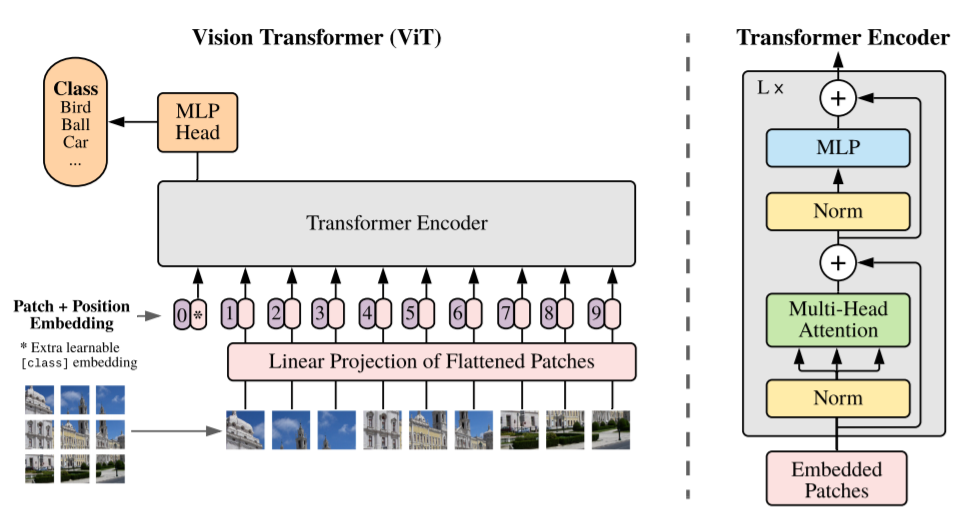

In [ ]:
class TransFormer(layers.Layer):
    def __init__(self, layer_num, num_heads, projection_dim, dropout=0.1, **kwargs):
        super(TransFormer, self).__init__(**kwargs)
        self.layer_num = layer_num
        self.num_heads = num_heads
        self.projection_dim = projection_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.norm1 = layers.LayerNormalization(epsilon=1e-6, name=f"ln1_{self.layer_num}")
        self.norm2 = layers.LayerNormalization(epsilon=1e-6, name=f"ln2_{self.layer_num}")

        self.add1 = Weighted_add(f"transformer_1_{self.layer_num}")
        self.add2 = Weighted_add(f"transformer_2_{self.layer_num}")

        self.mha = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.projection_dim,
            dropout=self.dropout,
            name=f"mha_{self.layer_num}"
        )

        self.dense1 = layers.Dense(self.projection_dim * 2, activation=tf.keras.activations.gelu)
        self.drop1 = layers.Dropout(self.dropout)

        self.dense2 = layers.Dense(self.projection_dim, activation=tf.keras.activations.gelu)
        self.drop2 = layers.Dropout(self.dropout)

    def call(self, inputs, training=None):
        # Multi-Head Attention block
        x1 = self.norm1(inputs)
        x1 = self.mha(x1, x1, training=training)
        x1 = self.add1(x1, inputs)   # residual with learned weighting

        # Feed Forward block
        x2 = self.norm2(x1)
        x2 = self.dense1(x2)
        x2 = self.drop1(x2, training=training)
        x2 = self.dense2(x2)
        x2 = self.drop2(x2, training=training)

        return self.add2(x2, x1)     # residual with learned weighting

    def get_config(self):
        config = super(TransFormer, self).get_config()
        config.update({
            "layer_num": self.layer_num,
            "num_heads": self.num_heads,
            "projection_dim": self.projection_dim,
            "dropout": self.dropout
        })
        return config

In [ ]:
class TransFormer_Block(layers.Layer):
    def __init__(self, num_layers, num_heads, projection_dim, dropout=0.1, **kwargs):
        super(TransFormer_Block, self).__init__(**kwargs)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.projection_dim = projection_dim
        self.dropout = dropout

    def build(self, input_shape):
        # Build list of TransFormer layers
        self.Blocks = [
            TransFormer(i, self.num_heads, self.projection_dim, self.dropout)
            for i in range(self.num_layers)
        ]

    def call(self, inputs, training=None):
        block_list = []
        x = inputs
        for i in range(self.num_layers):
            if i <= self.num_layers // 2:
                x = self.Blocks[i](x, training=training)
                block_list.append(x)
            else:
                x = self.Blocks[i](x, training=training)
                # Symmetric skip connection (mirror like U‑Net)
                x = layers.Add()([x, block_list[self.num_layers - i - 1]])
        return x

    def get_config(self):
        config = super(TransFormer_Block, self).get_config()
        config.update({
            "num_layers": self.num_layers,
            "num_heads": self.num_heads,
            "projection_dim": self.projection_dim,
            "dropout": self.dropout,
        })
        return config

In [ ]:
class Class_Token_Norm(layers.Layer):
    def __init__(self, eps=1e-6, **kwargs):
        super(Class_Token_Norm, self).__init__(**kwargs)
        self.eps = eps
        self.norm = layers.LayerNormalization(epsilon=self.eps)

    def call(self, inputs):
        # Normalize entire sequence, then extract CLS token
        x = self.norm(inputs)
        cls_token = x[:, 0, :]     # shape (B, D)
        return cls_token

    def get_config(self):
        config = super(Class_Token_Norm, self).get_config()
        config.update({
            "eps": self.eps
        })
        return config

In [ ]:
projection_dim = 256
num_heads = 4
transformer_layers = 12
dropout = 0.1          # dropout inside Transformer blocks

def create_vit_classifier(input_shape=(P_S, P_S, B),
                          num_classes=7,
                          use_pearson_corr=False,
                          dropout_rate=0.25,
                          method="with_gap"):
    inputs = layers.Input(shape=input_shape)

    # Optional Pearson correlation preprocessing
    if use_pearson_corr:
        x0 = Pearson_correlation_masked(P_S)(inputs)
    else:
        x0 = inputs

    # Patch creation
    patches = Patches(patch_size, embed_dim=projection_dim)(x0)

    # Patch encoding
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer stack
    encoded_patches = TransFormer_Block(transformer_layers, num_heads, projection_dim, dropout)(encoded_patches)
    encoded_patches = layers.Dropout(dropout_rate, name="TRAIN_DROPOUT_1")(encoded_patches)

    # Representation strategies
    if method == "with_cls_tkn":
        # ✅ normalize + extract CLS like senior code
        representation = Class_Token_Norm(eps=1e-6)(encoded_patches)
    elif method == "without_gap":
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = layers.Flatten()(representation)
    elif method == "with_gap":
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = tf.reduce_mean(representation, axis=1)  # [B, D]
    else:
        raise ValueError(f"Unknown method: {method}")

    # Classification head
    x = layers.Dense(512, activation=tf.keras.activations.gelu)(representation)
    x = layers.Dropout(dropout_rate, name="TRAIN_DROPOUT_3")(x)
    x = layers.Dense(256, activation=tf.keras.activations.gelu)(x)
    x = layers.Dense(128, activation=tf.keras.activations.gelu)(x)
    x = layers.Dropout(dropout_rate, name="TRAIN_DROPOUT_5")(x)
    x = layers.Dense(64, activation=tf.keras.activations.gelu)(x)
    features = layers.Dropout(dropout_rate, name="TRAIN_DROPOUT_6")(x)

    logits = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
model = create_vit_classifier(
    input_shape=(P_S, P_S, B),     # e.g., (patch_size, patch_size, 372)
    num_classes=num_classes,       # e.g., 13
    use_pearson_corr=use_pearson_corr,
    dropout_rate=dropout_rate,
    method="with_cls_tkn"          # exact spelling, no spaces!
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9, 9, 6)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patches (Patches)               │ (None, None, 256)      │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder (PatchEncoder)    │ (None, 10, 256)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trans_former__block             │ (None, 10, 256)        │    15,790,104 │
│ (TransFormer_Block)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TRAIN_DROPOUT_1 (Dropout)       │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class__token__norm              │ (None, 256)            │           512 │
│ (Class_Token_Norm)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TRAIN_DROPOUT_3 (Dropout)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TRAIN_DROPOUT_5 (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TRAIN_DROPOUT_6 (Dropout)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,177,823 (61.71 MB)

 Trainable params: 16,177,823 (61.71 MB)

 Non-trainable params: 0 (0.00 B)

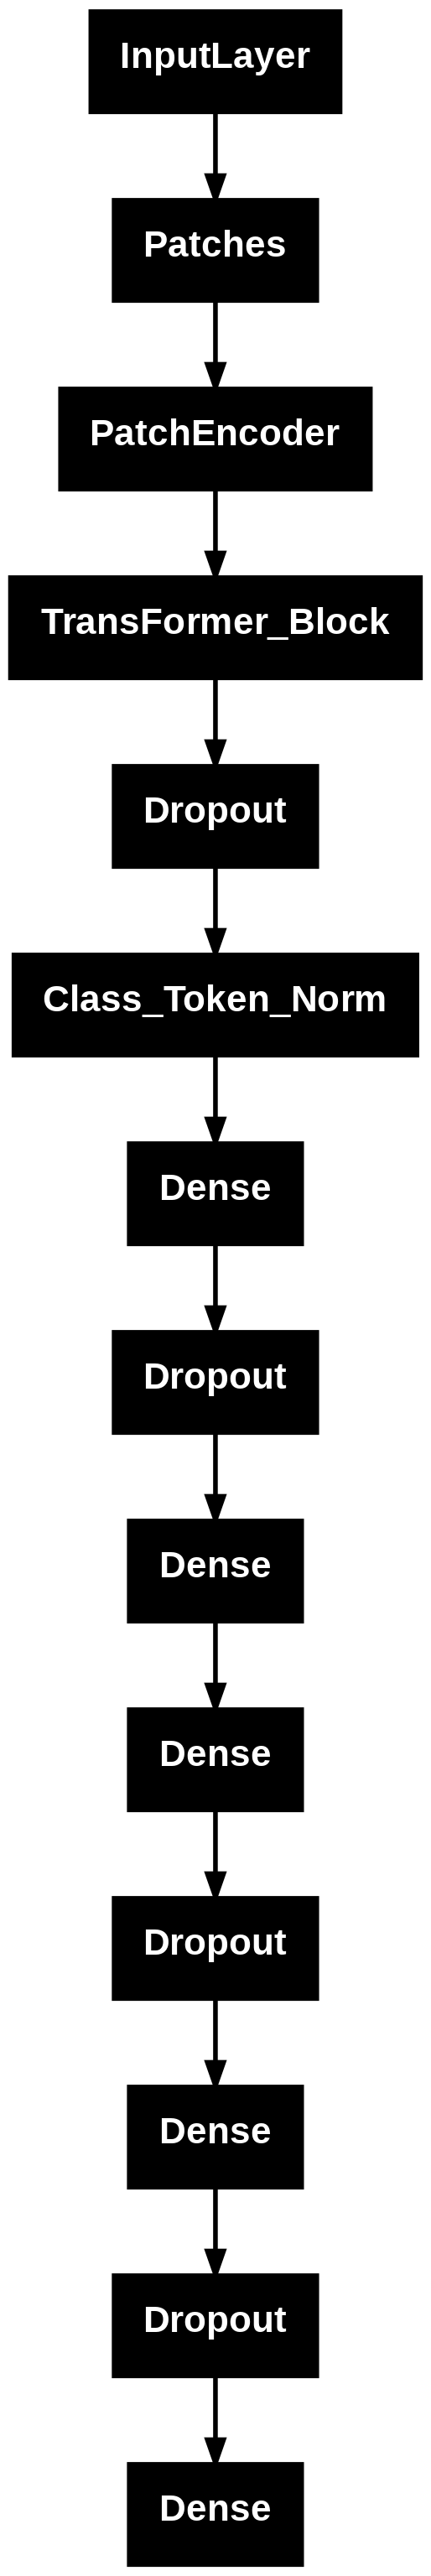

In [ ]:
# plot model architecture
plot_model(model,to_file = folder_path + "model_architecture.png", show_shapes=False)

# **Training**

Learning rate schedule: 0.0006 to 0.0006 to 1e-07


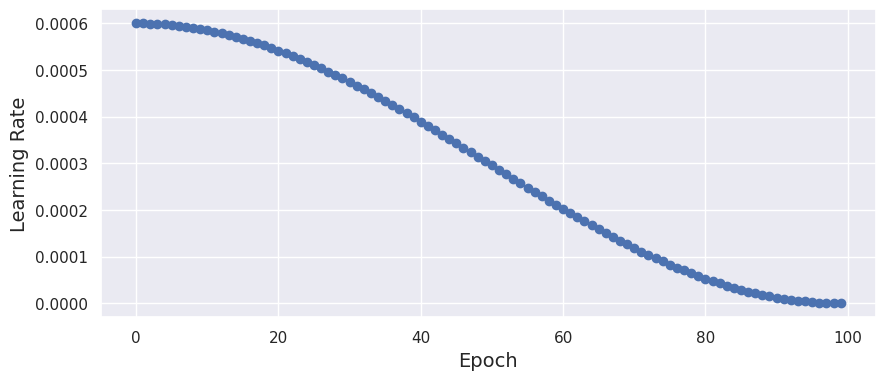

In [ ]:
LR_START = 3e-4
LR_MAX = 6e-4
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = epoch

def lrfn(epoch):
    # Single-phase cosine decay
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
          format(lr_y[0], max(lr_y), lr_y[-1]))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

In [ ]:
# .keras filepath
filepath = folder_path + "/Trained models/" + str(train_percent) + "% ps_" + str(P_S) + ".keras"

# Custom staged dropout shifter callback
model_shifter = CustomCallbacks(
    filepath,
    epochs=epoch,
    rate=dropout_rate,
    new_layer=Dropout_Train,
    layer_name="TRAIN_DROPOUT",
    accuracy_score=Targeted_accuracy,
    min_epochs=Min_trainable_epoch
)

# Standard checkpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='max')

# Compile
model.compile(
    optimizer=optimizers.Adam(3e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
import time

start_time = time.time()

# If you want staged dropout like senior → include Custom_callbacks here
callbacks_list = [checkpoint, lr_callback]  # + [model_shifter] if needed

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    validation_freq=1,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    shuffle=False,
    epochs=epoch
)

end_time = time.time()
tt = end_time - start_time
print("Total training time: ", tt, " seconds")


Epoch 1: LearningRateScheduler setting learning rate to 0.0006.
Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.5453 - loss: 1.2096
Epoch 1: val_accuracy improved from -inf to 0.79907, saving model to /content/drive/MyDrive/m_p/Uncertainty in Models/Vision Transformers/ViT with U-Net architecture/Without Pearson correlation/6_bands//Trained models/75% ps_9.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 160s 714ms/step - accuracy: 0.5462 - loss: 1.2072 - val_accuracy: 0.7991 - val_loss: 0.5295 - learning_rate: 6.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005998489878878364.
Epoch 2/100
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7987 - loss: 0.5606
Epoch 2: val_accuracy improved from 0.79907 to 0.88469, saving model to /content/drive/MyDrive/m_p/Uncertainty in Models/Vision Transformers/ViT with U-Net architecture/Without Pearson correlation/6_bands//Trained models/75% ps_9.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.7

In [ ]:
gc.collect()

16093

In [ ]:
# Load with custom layers
custom_objects = {
    "Patches": Patches,
    "PatchEncoder": PatchEncoder,
    "TransFormer_Block": TransFormer_Block,
    "Class_Token_Norm": Class_Token_Norm,
    # include all other custom blocks if needed:
    "Weighted_add": Weighted_add,
    "TransFormer": TransFormer,
}
model = tf.keras.models.load_model(filepath, custom_objects=custom_objects)

print("✅ Model loaded successfully!")
model.summary()

# Also manually check parameter counts (like senior’s code)
Trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
Non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
Total_params = Trainable_params + Non_trainable_params

print(f"\nTotal params: {Total_params:,}")
print(f"Trainable params: {Trainable_params:,}")
print(f"Non-trainable params: {Non_trainable_params:,}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'class__token__norm', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


✅ Model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9, 9, 6)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patches (Patches)               │ (None, None, 256)      │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder (PatchEncoder)    │ (None, 10, 256)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trans_former__block             │ (None, 10, 256)        │    15,790,104 │
│ (TransFormer_Block)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TRAIN_DROPOUT_1 (Dropout)       │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class__token__norm              │ (None, 256)            │           512 │
│ (Class_Token_Norm)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TRAIN_DROPOUT_3 (Dropout)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TRAIN_DROPOUT_5 (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TRAIN_DROPOUT_6 (Dropout)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,533,471 (185.14 MB)

 Trainable params: 16,177,823 (61.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,355,648 (123.43 MB)


Total params: 16,177,823.0
Trainable params: 16,177,823
Non-trainable params: 0.0


In [ ]:
Trainable_params = 0
for i in model.trainable_weights :
    Trainable_params+= np.prod(i.shape)

Non_trainable_params = 0
for i in model.non_trainable_weights:
    Non_trainable_params+= np.prod(i.shape)

Total_params = Trainable_params + Non_trainable_params
parameters_summary = [Total_params, Trainable_params, Non_trainable_params]

print("Total_params: ", Total_params)
print("Trainable_params: ", Trainable_params)
print("Non_trainable_params: ", Non_trainable_params)

Total_params:  16177823
Trainable_params:  16177823
Non_trainable_params:  0


# **Model Performance**

In [ ]:
y_pred = model.predict(x_test, verbose = -1).argmax(axis = -1)

In [ ]:
y_pred.shape, y_test.shape

((4310,), (4310,))

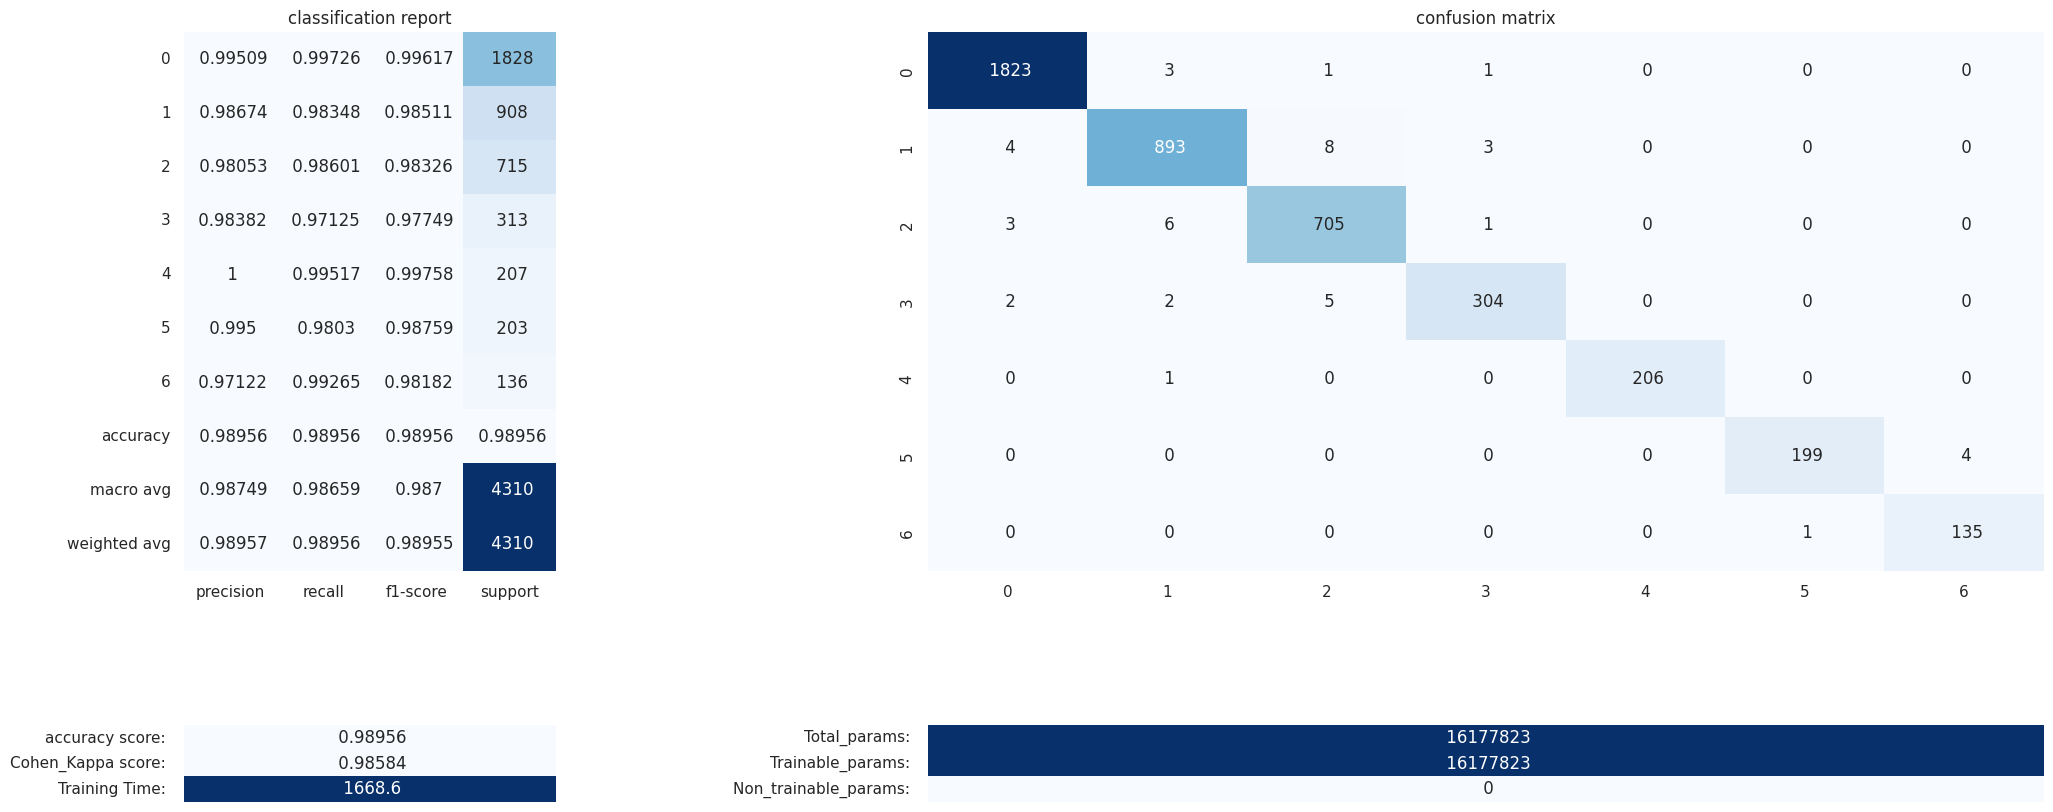

In [ ]:
performance_meausures(y_test, y_pred, tt, *parameters_summary, folder_path = folder_path)

In [ ]:
for _ in range(5):
    gc.collect()

In [ ]:
for i in model.trainable_weights:
    if "weighted_add_weighted_add" in str(i):
        print(f"{i.name[13:]}  ------> {i.numpy()[0,0,0]}")

In [ ]:
filepath1 = folder_path +"Results/"+ str(train_percent)+"% ps_" +str(P_S) + " performance" + ".txt"
results = confusion_matrix(y_test,y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(" ", file = open(filepath1, "a"))
print("P_S = ", P_S, file = open(filepath1, "a"))
print('Confusion Matrix :', file=open(filepath1,"a"))
print(results, file=open(filepath1,"a"))

print('Report : ', file=open(filepath1,"a"))
print(report, file=open(filepath1,"a"))

print('Accuracy Score :', accuracy, file=open(filepath1,"a"))
print('Cohen_Kappa: ', kappa, file=open(filepath1,"a"))
print('Training Time:', tt, file=open(filepath1,"a"))

print("\033[1m", 'Confusion Matrix :', "\033[0m")
print(results)
print("\033[1m", 'Report : ', "\033[0m")
print(report)
print("\033[1m", 'Accuracy Score :', "\033[0m", accuracy)
print("\033[1m", 'Cohen_Kappa: ',  "\033[0m", kappa)
print("\033[1m", 'Training Time:', "\033[0m", tt)
print("\033[1m", "Total_params: ", "\033[0m", Total_params)
print("\033[1m", "Trainable_params: ", "\033[0m", Trainable_params)
print("\033[1m", "Non_trainable_params: ", "\033[0m", Non_trainable_params)

 Confusion Matrix : 
[[1823    3    1    1    0    0    0]
 [   4  893    8    3    0    0    0]
 [   3    6  705    1    0    0    0]
 [   2    2    5  304    0    0    0]
 [   0    1    0    0  206    0    0]
 [   0    0    0    0    0  199    4]
 [   0    0    0    0    0    1  135]]
 Report :  
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1828
           1       0.99      0.98      0.99       908
           2       0.98      0.99      0.98       715
           3       0.98      0.97      0.98       313
           4       1.00      1.00      1.00       207
           5       0.99      0.98      0.99       203
           6       0.97      0.99      0.98       136

    accuracy                           0.99      4310
   macro avg       0.99      0.99      0.99      4310
weighted avg       0.99      0.99      0.99      4310

 Accuracy Score :  0.9895591647331786
 Cohen_Kappa:   0.9858353278535515
 Training Time:  1668.57112264

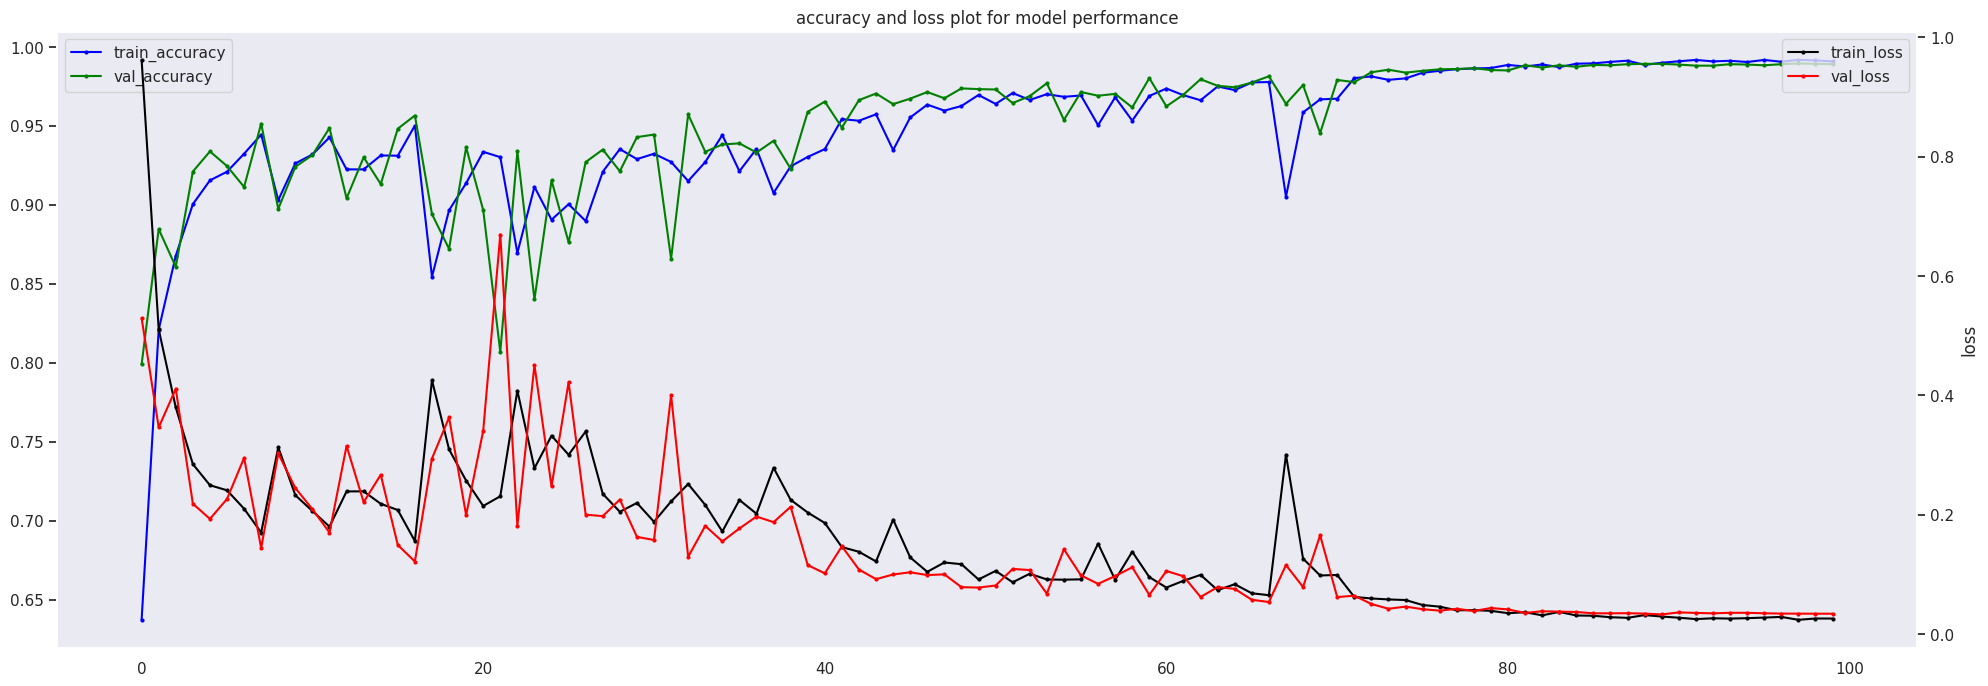

In [ ]:
plot_accuracy_loss_curve(history, use_pearson_corr = use_pearson_corr, folder_path = folder_path)

image predicted ███████████████ 50%
image predicted ███████████████████████████████ 100%
Time taken: 1.07 min


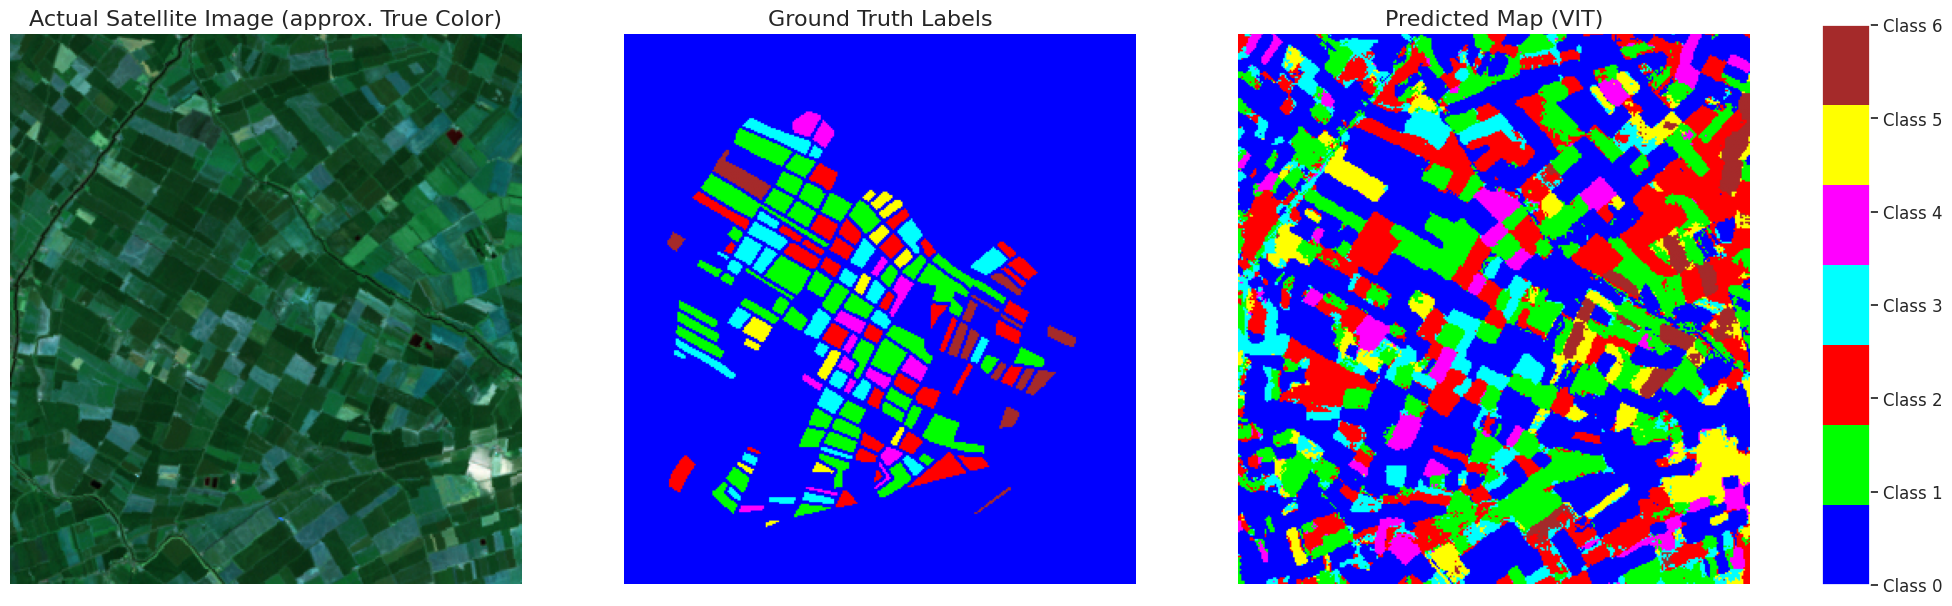

✅ Figure displayed and saved to Excel:
/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/conformal_reports.xlsx


In [ ]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
import pandas as pd

# Define ViT-style color map
vit_style_colors = [
    '#0000FF', # Blue
    '#00FF00', # Green
    '#FF0000', # Red
    '#00FFFF', # Cyan
    '#FF00FF', # Magenta
    '#FFFF00', # Yellow
    '#A52A2A', # Brown
]
better_cmap = ListedColormap(vit_style_colors)


# ------------------------------------------------------------------
# Model Prediction
# ------------------------------------------------------------------
def predict_prob_half_image(model, padded_x, H, W_range, B, P_S, num_classes):
    y_hat_probs = np.zeros((H, W_range, num_classes))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i, :, :, :] = padded_x[i:i + P_S, j:j + P_S, :]
        y_pred_probs = model.predict(patchs, verbose=0)
        y_hat_probs[:, j, :] = y_pred_probs
    return y_hat_probs


def predict_probabilities_image(model, padded_x, H, W, B, P_S, num_classes):
    import time, gc
    start_time = time.time()
    pad_width = int((P_S - 1) / 2)
    half_1 = padded_x.shape[1] // 2 + pad_width + 1
    half_2 = padded_x.shape[1] // 2 - pad_width - 1
    padded_x_1st_half = padded_x[:, :half_1, :]
    padded_x_2nd_half = padded_x[:, half_2:, :]
    del padded_x; gc.collect()
    y_hat_all_probs = np.zeros((H, W, num_classes))

    # Half 1
    y_hat_all_probs[:, :W // 2, :] = predict_prob_half_image(model, padded_x_1st_half, H, W // 2, B, P_S, num_classes)
    print("image predicted ███████████████ 50%")

    # Half 2
    y_hat_all_probs[:, W // 2:, :] = predict_prob_half_image(model, padded_x_2nd_half, H, W - (W // 2), B, P_S, num_classes)
    print("image predicted ███████████████████████████████ 100%")

    end_time = time.time()
    print(f"Time taken: {(end_time - start_time) / 60:.2f} min")
    return y_hat_all_probs


# ------------------------------------------------------------------
# Visualization + Excel export
# ------------------------------------------------------------------
def visualize_and_save_to_excel(model, padded_x, x, y, H, W, B, P_S, num_classes,
                                save_dir, filename="conformal_reports.xlsx"):
    # Predict
    prob_pred = predict_probabilities_image(model, padded_x, H, W, B, P_S, num_classes)
    pred_class = np.argmax(prob_pred, axis=2)

    # Prepare RGB image (example: bands 2, 4, 5)
    rgb_bands_indices = [2, 4, 5]
    rgb_image = (x[:, :, rgb_bands_indices] * 255).astype("uint8")
    rgb_norm = rgb_image / 255.0  # Normalize for imshow

    # Create side-by-side comparison figure
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

    # Image 1: True-color Satellite
    axes[0].imshow(rgb_norm)
    axes[0].set_title("Actual Satellite Image (approx. True Color)", fontsize=16)
    axes[0].axis("off")

    # Image 2: Ground Truth
    axes[1].imshow(y, cmap=better_cmap, vmin=0, vmax=num_classes-1)
    axes[1].set_title("Ground Truth Labels", fontsize=16)
    axes[1].axis("off")

    # Image 3: Prediction Map
    im = axes[2].imshow(pred_class, cmap=better_cmap, vmin=0, vmax=num_classes-1)
    axes[2].set_title("Predicted Map (VIT)", fontsize=16)
    axes[2].axis("off")

    # Shared colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(num_classes))
    cbar.set_ticklabels([f"Class {i}" for i in range(num_classes)])
    cbar.ax.tick_params(labelsize=12)

    # ➡️ SHOW FIGURE in the notebook / script (like before)
    plt.show()

    # Also SAVE to Excel
    os.makedirs(save_dir, exist_ok=True)

    img_buffer = io.BytesIO()
    fig.savefig(img_buffer, format="png", bbox_inches="tight")
    img_buffer.seek(0)
    plt.close(fig)

    excel_path = os.path.join(save_dir, filename)

    # Create or append Excel file
    if not os.path.exists(excel_path):
        df = pd.DataFrame({"Info": ["VITModel Output"]})
        df.to_excel(excel_path, index=False)
        wb = load_workbook(excel_path)
    else:
        wb = load_workbook(excel_path)

    ws = wb.create_sheet(title=f"Run_{len(wb.sheetnames)}")
    xl_img = XLImage(img_buffer)
    xl_img.anchor = "A1"
    ws.add_image(xl_img)

    ws["C40"] = "Saved by VITscript"
    ws["C41"] = "Displayed and exported successfully"

    wb.save(excel_path)
    print(f"✅ Figure displayed and saved to Excel:\n{excel_path}")


visualize_and_save_to_excel(
    model, padded_x, x, y, H, W, B, P_S, num_classes,
    save_dir="/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/"
)

#  **Split Conformal Prediction**

Calibration set size: 2155 | Test set size: 2155
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

✅ Softmax probabilities generated. Inference time: 8.31s

--- Standard Split Conformal Prediction Results ---
Target Coverage: 0.950
Empirical Test Coverage: 0.951
Average Prediction Set Size: 0.952

✅ Graph saved to 'Per-Class Coverage' in '/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/conformal_reports.xlsx'


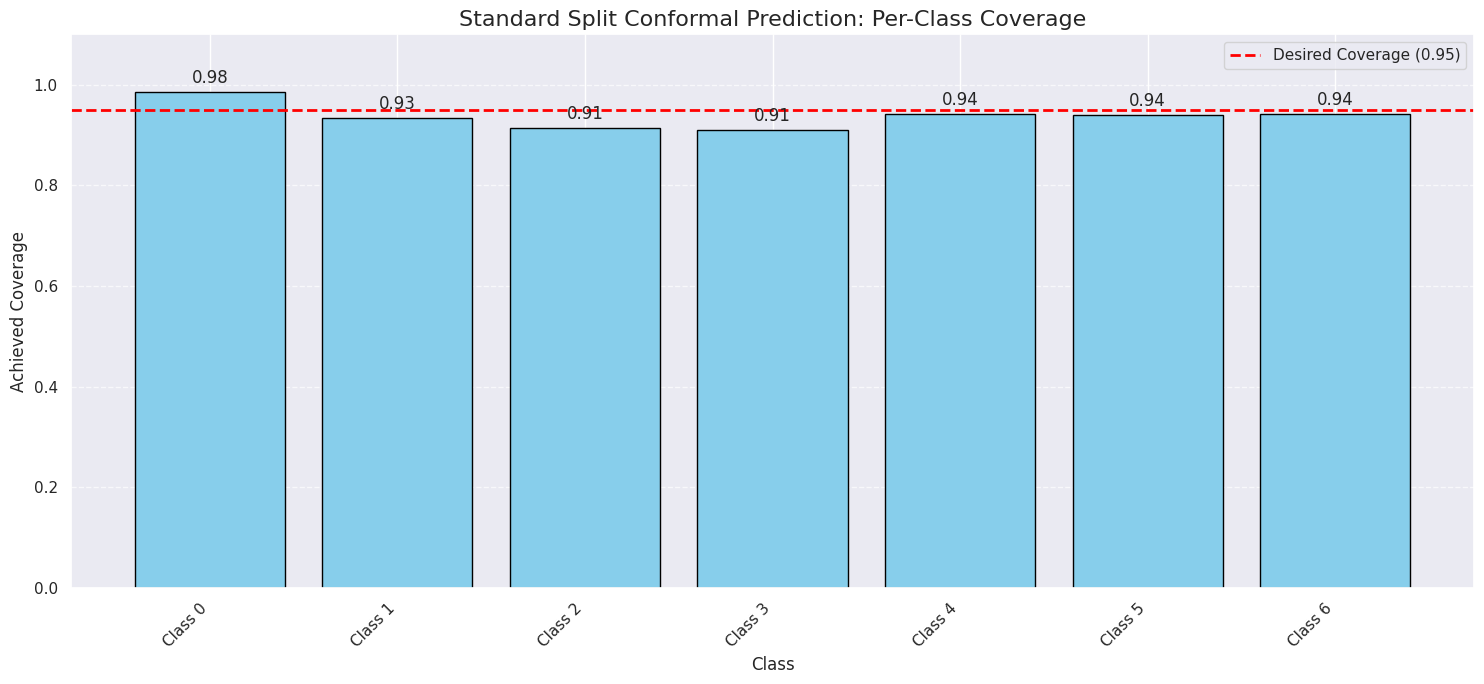

In [ ]:
# --- ADDED: Install & imports for Excel handling ---
!pip install openpyxl --quiet

import os
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import time
import openpyxl
from openpyxl.drawing.image import Image as OpenPyXLImage

# ✅ DEFINE SAVE SETTINGS
output_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/"
excel_filename = "conformal_reports.xlsx"
excel_file_path = os.path.join(output_dir, excel_filename)
sheet_name = "Per-Class Coverage"

os.makedirs(output_dir, exist_ok=True)

# --- 1. Split Original Test Set into Calibration & Evaluation Sets ---
x_test_np = x_test.numpy() if hasattr(x_test, "numpy") else x_test
y_test_np = y_test.numpy() if hasattr(y_test, "numpy") else y_test

x_calib_np, x_test_new_np, y_calib_np, y_test_new_np = train_test_split(
    x_test_np, y_test_np, test_size=0.5, stratify=y_test_np, random_state=42
)

print(f"Calibration set size: {len(x_calib_np)} | Test set size: {len(x_test_new_np)}")

# --- 2. Get Model Probabilities ---
start_time = time.time()
calib_probs = model.predict(x_calib_np, batch_size=64, verbose=1)
test_probs = model.predict(x_test_new_np, batch_size=64, verbose=1)
end_time = time.time()
print(f"\n✅ Softmax probabilities generated. Inference time: {end_time - start_time:.2f}s")

# --- 3. Split Conformal Prediction Calibration ---
alpha = 0.05
n_calib = len(y_calib_np)

calib_scores_split = 1 - calib_probs[np.arange(n_calib), y_calib_np]
q_level_split = np.ceil((n_calib + 1) * (1 - alpha)) / n_calib
q_hat_split = np.quantile(calib_scores_split, q_level_split, method="higher")

prediction_sets_split = test_probs >= (1 - q_hat_split)

empirical_coverage_split = (
    prediction_sets_split[np.arange(len(y_test_new_np)), y_test_new_np]
).mean()
avg_set_size_split = prediction_sets_split.sum(axis=1).mean()

print("\n--- Standard Split Conformal Prediction Results ---")
print(f"Target Coverage: {1-alpha:.3f}")
print(f"Empirical Test Coverage: {empirical_coverage_split:.3f}")
print(f"Average Prediction Set Size: {avg_set_size_split:.3f}")

# --- 4. Per-Class Coverage Plot ---
num_classes = test_probs.shape[1]
class_labels = [f"Class {i}" for i in range(num_classes)]
coverages_split = []

y_test_new_np = np.array(y_test_new_np).reshape(-1)
for i in range(num_classes):
    class_mask = (y_test_new_np == i)
    if class_mask.sum() == 0:
        coverages_split.append(np.nan)
        continue
    coverages_split.append(prediction_sets_split[class_mask, i].mean())

coverages_split = np.array(coverages_split)

# --- 5. Plot Coverage Bar Chart ---
plt.figure(figsize=(15, 7))
bars = plt.bar(class_labels, coverages_split, color="skyblue", edgecolor="black")

for bar in bars:
    yval = bar.get_height()
    if not np.isnan(yval):
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.01, f"{yval:.2f}",
                 ha="center", va="bottom")

plt.axhline(y=(1 - alpha), color="red", linestyle="--", linewidth=2,
            label=f"Desired Coverage ({1-alpha:.2f})")

plt.title("Standard Split Conformal Prediction: Per-Class Coverage", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Achieved Coverage", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# --- 6. Save Plot to Excel ---
image_buffer = io.BytesIO()
plt.savefig(image_buffer, format="png", bbox_inches="tight")
image_buffer.seek(0)

if os.path.exists(excel_file_path):
    workbook = openpyxl.load_workbook(excel_file_path)
    if sheet_name in workbook.sheetnames:
        del workbook[sheet_name]
    sheet = workbook.create_sheet(title=sheet_name)
else:
    workbook = openpyxl.Workbook()
    sheet = workbook.active
    sheet.title = sheet_name

img = OpenPyXLImage(image_buffer)
sheet.add_image(img, "A1")
workbook.save(excel_file_path)

print(f"\n✅ Graph saved to '{sheet_name}' in '{excel_file_path}'")

plt.show()
plt.close(plt.gcf())

ℹ️ Generating prob_pred using model.predict_probabilities_image(...)
image predicted ███████████████ 50%
image predicted ███████████████████████████████ 100%
Time taken: 1.18 min
ℹ️ Creating class predictions (pred_class) from prob_pred using argmax...


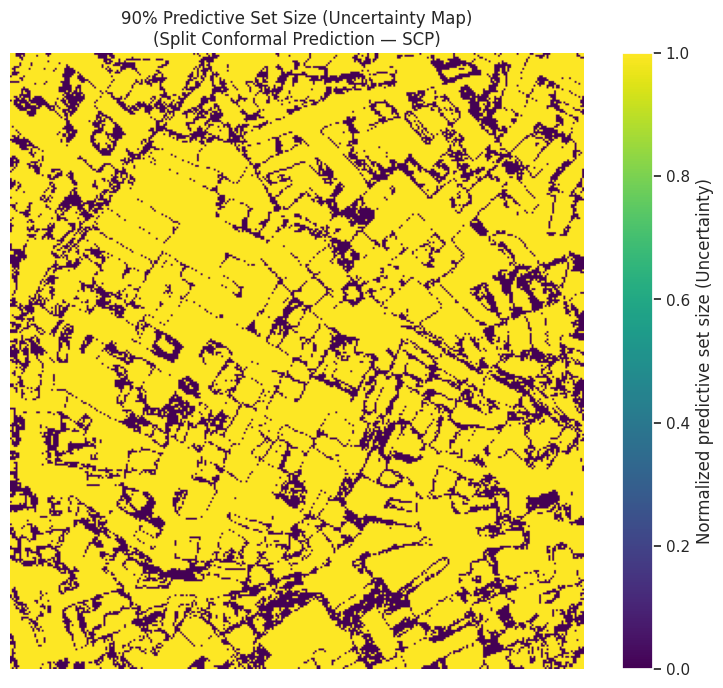

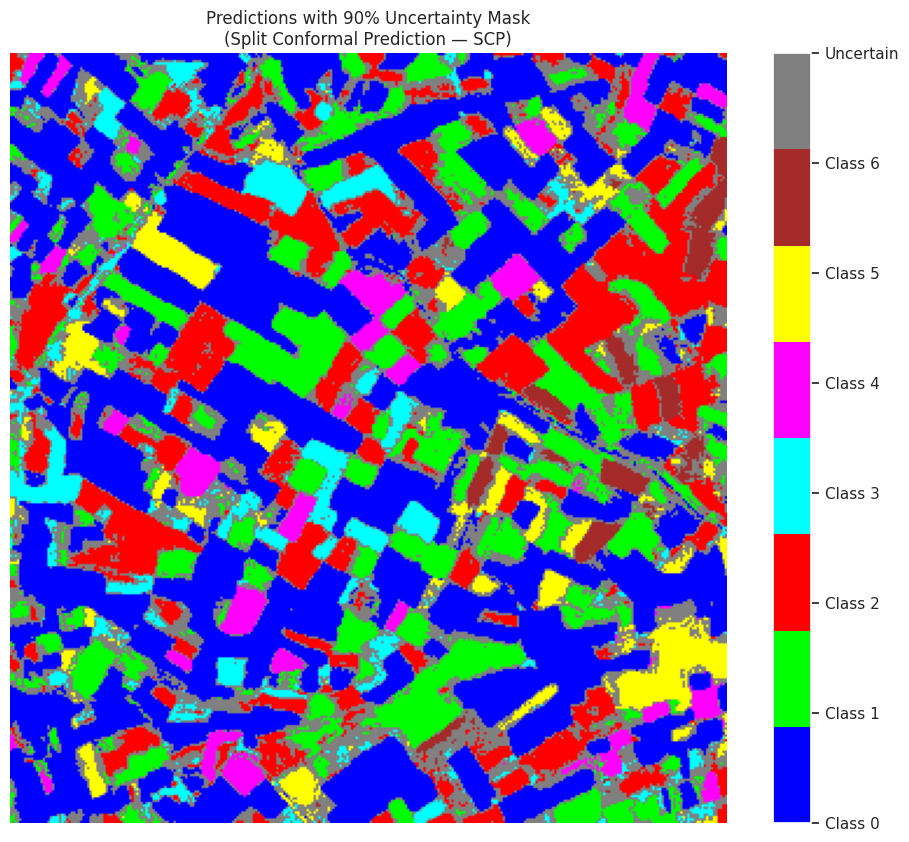

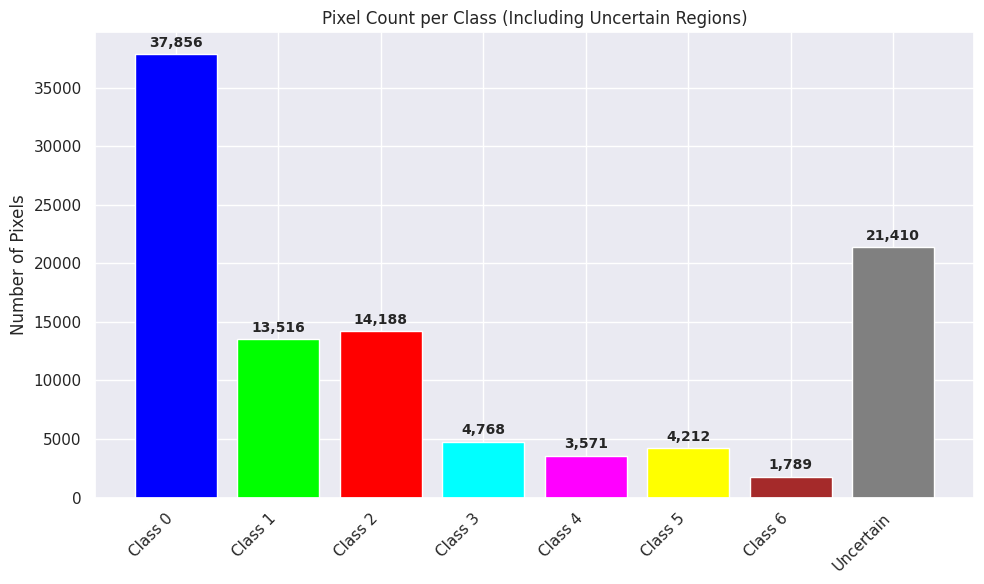

✅ Plots displayed and saved successfully to Excel:
/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/conformal_reports.xlsx


In [ ]:
# -------------------------------------------------------
# 🟧 UNCERTAINTY MAPS VISUALIZATION — Split Conformal Prediction (SCP)
# -------------------------------------------------------

import os
import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from openpyxl import Workbook, load_workbook
from openpyxl.drawing.image import Image as XLImage

# -------------------------------------------------------
# 🔧 Settings
# -------------------------------------------------------
output_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/"
excel_filename = "conformal_reports.xlsx"
excel_path = os.path.join(output_dir, excel_filename)
os.makedirs(output_dir, exist_ok=True)

# -------------------------------------------------------
# ✅ STEP 1. Ensure required variables exist
# -------------------------------------------------------
required = ["model", "H", "W", "B", "P_S", "num_classes"]
for v in required:
    if v not in locals():
        raise NameError(f"❌ Variable '{v}' is missing. Please define it before running this cell.")

# If prob_pred is missing, generate it
if "prob_pred" not in locals():
    print("ℹ️ Generating prob_pred using model.predict_probabilities_image(...)")
    prob_pred = predict_probabilities_image(model, padded_x, H, W, B, P_S, num_classes)

# If pred_class is missing, compute it from prob_pred
if "pred_class" not in locals():
    print("ℹ️ Creating class predictions (pred_class) from prob_pred using argmax...")
    pred_class = np.argmax(prob_pred, axis=-1)

# Likewise, ensure q_hat_split exists
if "q_hat_split" not in locals():
    raise NameError("❌ 'q_hat_split' is missing. Please run your calibration cell first to compute it.")

# -------------------------------------------------------
# ✅ STEP 2. Compute predictive-set sizes (auto 2D/3D)
# -------------------------------------------------------
predictive_sets = prob_pred > (1 - q_hat_split)
if predictive_sets.ndim == 3:
    set_sizes = np.sum(predictive_sets, axis=2)
elif predictive_sets.ndim == 2:
    set_sizes = np.sum(predictive_sets, axis=1)
    if "H" in locals() and "W" in locals() and H * W == set_sizes.size:
        set_sizes = set_sizes.reshape(H, W)
        pred_class = pred_class.reshape(H, W)
    else:
        print("⚠️ Could not reshape set_sizes to image grid; using flattened form.")
else:
    raise ValueError(f"Unexpected array shape {predictive_sets.shape} — expected 2D or 3D.")

# -------------------------------------------------------
# 🌈 STEP 3. Normalize predictive-set sizes
# -------------------------------------------------------
norm_set_sizes = (set_sizes - set_sizes.min()) / (set_sizes.max() - set_sizes.min())

# -------------------------------------------------------
# 🎨 STEP 4. Predictive Set Size (Uncertainty Map)
# -------------------------------------------------------
fig1 = plt.figure(figsize=(10, 8))
plt.imshow(norm_set_sizes, cmap="viridis")
plt.colorbar(label="Normalized predictive set size (Uncertainty)")
plt.title("90% Predictive Set Size (Uncertainty Map)\n(Split Conformal Prediction — SCP)")
plt.axis("off")
plt.show()

buf1 = io.BytesIO()
fig1.savefig(buf1, format="png", bbox_inches="tight")
buf1.seek(0)
plt.close(fig1)

# -------------------------------------------------------
# 🎭 STEP 5. Masked Prediction Map with Uncertain Regions
# -------------------------------------------------------
vit_colors = ['#0000FF', '#00FF00', '#FF0000', '#00FFFF', '#FF00FF', '#FFFF00', '#A52A2A']
custom_cmap = ListedColormap(vit_colors + ['#808080'])  # gray = uncertain

combined_map = np.where(set_sizes == 1, pred_class, num_classes)

fig2 = plt.figure(figsize=(12, 10))
plt.imshow(combined_map, cmap=custom_cmap)
plt.title("Predictions with 90% Uncertainty Mask\n(Split Conformal Prediction — SCP)")

cbar = plt.colorbar(ticks=np.arange(num_classes + 1))
cbar.set_ticklabels([f"Class {i}" for i in range(num_classes)] + ["Uncertain"])
plt.axis("off")
plt.show()

buf2 = io.BytesIO()
fig2.savefig(buf2, format="png", bbox_inches="tight")
buf2.seek(0)
plt.close(fig2)

# -------------------------------------------------------
# 📊 STEP 6. Bar Chart — Pixel Counts per Class
# -------------------------------------------------------
unique_classes, counts = np.unique(combined_map, return_counts=True)
labels = [f"Class {i}" for i in range(num_classes)] + ["Uncertain"]
pixel_counts = [counts[unique_classes == i][0] if i in unique_classes else 0
                for i in range(num_classes + 1)]

fig3 = plt.figure(figsize=(10, 6))
bars = plt.bar(labels, pixel_counts, color=list(vit_colors) + ['#808080'])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Pixels")
plt.title("Pixel Count per Class (Including Uncertain Regions)")

# add numeric pixel counts on top of bars
for bar, count in zip(bars, pixel_counts):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + (max(pixel_counts)*0.01 if max(pixel_counts) else 1),
             f"{count:,}", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

buf3 = io.BytesIO()
fig3.savefig(buf3, format="png", bbox_inches="tight")
buf3.seek(0)
plt.close(fig3)

# -------------------------------------------------------
# 💾 STEP 7. Save All Three Figures to Excel
# -------------------------------------------------------
if not os.path.exists(excel_path):
    wb = Workbook()
    ws = wb.active
    ws.title = "Info"
    ws["A1"] = "Conformal Prediction Reports"
    ws["A2"] = "Created automatically by visualization script"
    wb.save(excel_path)
    print(f"Created new Excel file at {excel_path}")

wb = load_workbook(excel_path)
sheet_name = f"SCP_Run_{len(wb.sheetnames)}"
ws = wb.create_sheet(title=sheet_name)

xl_img1, xl_img2, xl_img3 = XLImage(buf1), XLImage(buf2), XLImage(buf3)
xl_img1.anchor, xl_img2.anchor, xl_img3.anchor = "A1", "N1", "A25"
for img in [xl_img1, xl_img2, xl_img3]:
    ws.add_image(img)

ws["A48"] = "Saved by SCP Visualization Script"
ws["A49"] = "Includes Uncertainty Map, Masked Prediction Map, and Class Distribution"

wb.save(excel_path)
print(f"✅ Plots displayed and saved successfully to Excel:\n{excel_path}")

# **Class wise Conformal Prediction**


--- Starting Class-wise Conformal Prediction ---
Size of calibration set: 2155
Size of new test set: 2155
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Inference time: 1.07 seconds

Calibrating per class...

--- Results ---
Target Coverage: 0.950
Empirical Coverage: 0.948
Average Prediction Set Size: 0.950
Saved plot to 'Classwise Coverage' in '/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/conformal_reports.xlsx'


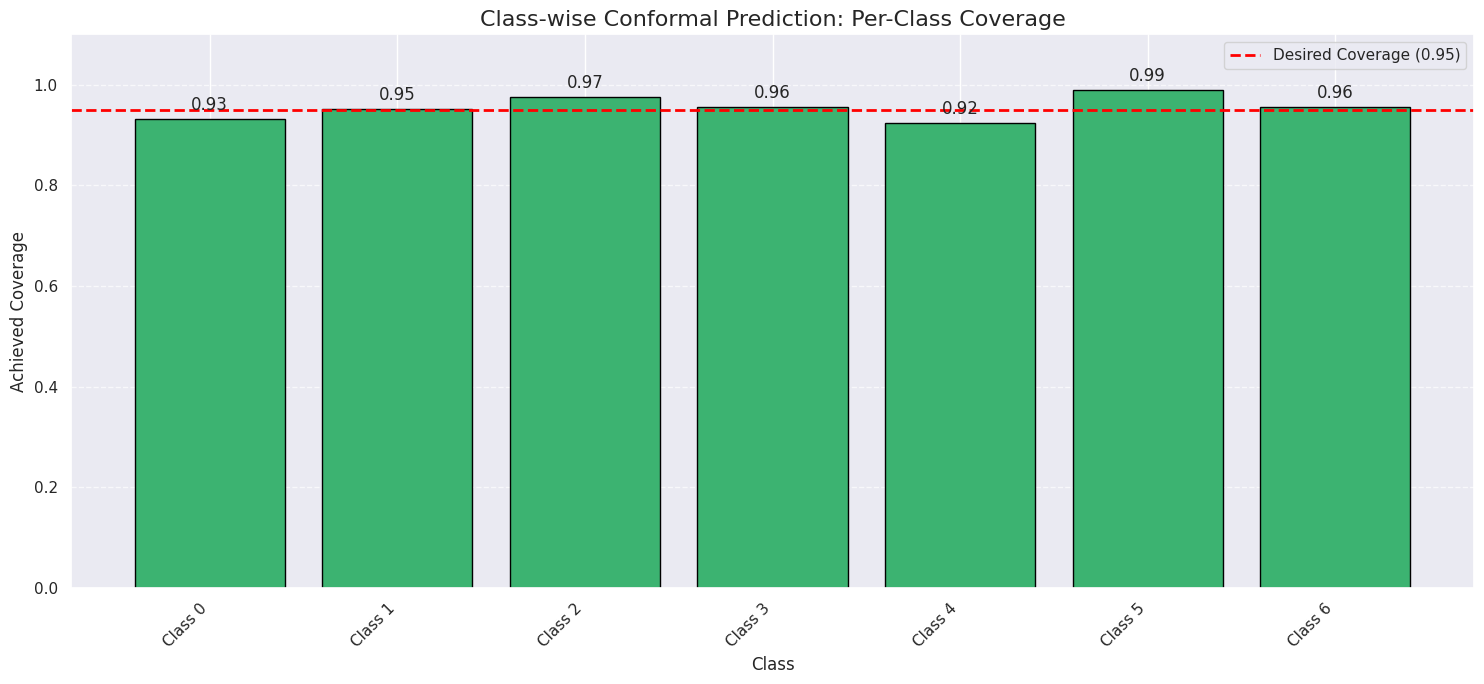

In [ ]:
# -------------------------------------------------------
# CLASS-WISE CONFORMAL PREDICTION (Generates thresholds + Excel plot)
# -------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
import os, io, openpyxl
from openpyxl.drawing.image import Image as OpenPyXLImage


def classwise_conformal_prediction_keras(model, x_test, y_test, alpha=0.05, batch_size=64):
    """
    Performs class-wise Conformal Prediction uncertainty analysis using a Keras model.
    Returns q_hats_classwise so later visualization can reuse thresholds.
    """

    print("\n--- Starting Class-wise Conformal Prediction ---")

    # 1️ Split test data into calibration and evaluation sets
    x_calib, x_test_new, y_calib, y_test_new = train_test_split(
        np.array(x_test), np.array(y_test),
        test_size=0.5, stratify=y_test, random_state=42
    )
    y_calib = y_calib.reshape(-1)
    y_test_new = y_test_new.reshape(-1)

    print(f"Size of calibration set: {len(x_calib)}")
    print(f"Size of new test set: {len(x_test_new)}")

    # 2️ Generate softmax probabilities using the Keras model
    start_time = time.time()
    calib_probs = model.predict(x_calib, batch_size=batch_size, verbose=1)
    test_probs = model.predict(x_test_new, batch_size=batch_size, verbose=1)
    end_time = time.time()
    print(f"Inference time: {end_time - start_time:.2f} seconds")

    # 3️ Compute per-class quantiles (class-wise calibration)
    num_classes = calib_probs.shape[1]
    q_hats_classwise = np.zeros(num_classes)

    print("\nCalibrating per class...")
    for i in range(num_classes):
        mask = (y_calib == i)
        if mask.sum() == 0:
            q_hats_classwise[i] = 1.0
            continue
        scores = 1 - calib_probs[mask, i]
        n_i = mask.sum()
        q_level = np.ceil((n_i + 1) * (1 - alpha)) / n_i
        q_hats_classwise[i] = np.quantile(scores, q_level, method="higher")

    # 4️⃣ Prediction sets & evaluation
    conf_thresholds = 1 - q_hats_classwise
    prediction_sets_cw = test_probs >= conf_thresholds

    empirical_coverage_cw = (
        prediction_sets_cw[np.arange(len(y_test_new)), y_test_new]
    ).mean()
    avg_set_size_cw = prediction_sets_cw.sum(axis=1).mean()

    print("\n--- Results ---")
    print(f"Target Coverage: {1-alpha:.3f}")
    print(f"Empirical Coverage: {empirical_coverage_cw:.3f}")
    print(f"Average Prediction Set Size: {avg_set_size_cw:.3f}")

    # 5️⃣ Per-class coverage plot
    coverages_classwise = []
    for i in range(num_classes):
        class_mask = (y_test_new == i)
        if class_mask.sum() == 0:
            coverages_classwise.append(np.nan)
            continue
        sets_i = prediction_sets_cw[class_mask]
        coverages_classwise.append(sets_i[:, i].mean())
    coverages_classwise = np.array(coverages_classwise)

    class_labels = [f"Class {i}" for i in range(num_classes)]
    plt.figure(figsize=(15, 7))
    bars = plt.bar(class_labels, coverages_classwise, color="mediumseagreen", edgecolor="black")
    for bar in bars:
        yval = bar.get_height()
        if not np.isnan(yval):
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}",
                     ha="center", va="bottom")
    plt.axhline(y=(1-alpha), color="red", linestyle="--", linewidth=2,
                label=f"Desired Coverage ({1-alpha:.2f})")
    plt.title("Class-wise Conformal Prediction: Per-Class Coverage", fontsize=16)
    plt.xlabel("Class"); plt.ylabel("Achieved Coverage")
    plt.xticks(rotation=45, ha="right"); plt.ylim(0, 1.1)
    plt.legend(); plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # 6️⃣ Save plot to Excel
    output_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/"
    excel_filename = "conformal_reports.xlsx"
    excel_path = os.path.join(output_dir, excel_filename)
    sheet_name = "Classwise Coverage"

    try:
        os.makedirs(output_dir, exist_ok=True)
        buf = io.BytesIO(); plt.savefig(buf, format="png", bbox_inches="tight"); buf.seek(0)
        if os.path.exists(excel_path):
            wb = openpyxl.load_workbook(excel_path)
            if sheet_name in wb.sheetnames: del wb[sheet_name]
            sheet = wb.create_sheet(title=sheet_name)
        else:
            wb = openpyxl.Workbook(); sheet = wb.active; sheet.title = sheet_name
        img = OpenPyXLImage(buf); sheet.add_image(img, "A1"); wb.save(excel_path)
        print(f"Saved plot to '{sheet_name}' in '{excel_path}'")
    except Exception as e:
        print(f"Excel save failed: {e}")

    plt.show(); plt.close()

    # 7️⃣ Return metrics + thresholds
    return {
        "coverage": empirical_coverage_cw,
        "avg_set_size": avg_set_size_cw,
        "per_class_coverages": coverages_classwise,
        "q_hats_classwise": q_hats_classwise
    }

# Run calibration
results = classwise_conformal_prediction_keras(model, x_test, y_test, alpha=0.05, batch_size=64)
q_hats_classwise = results["q_hats_classwise"]

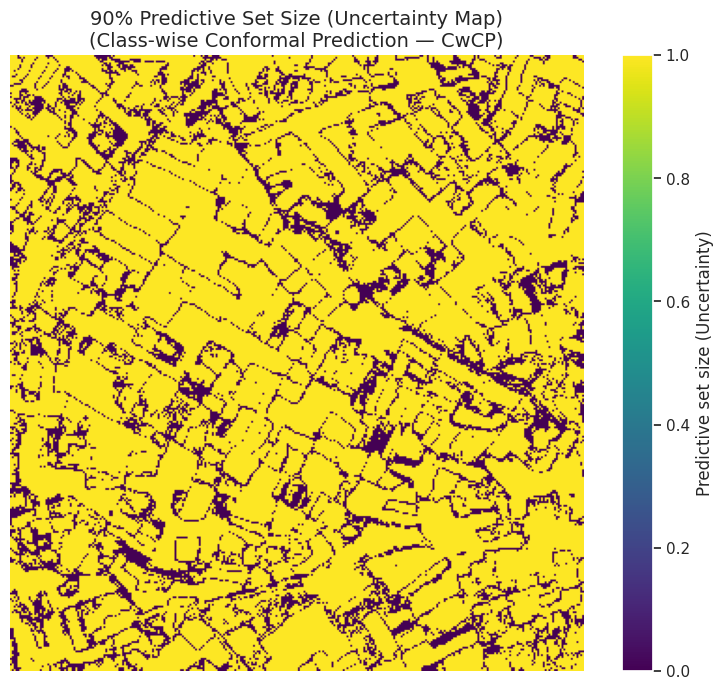

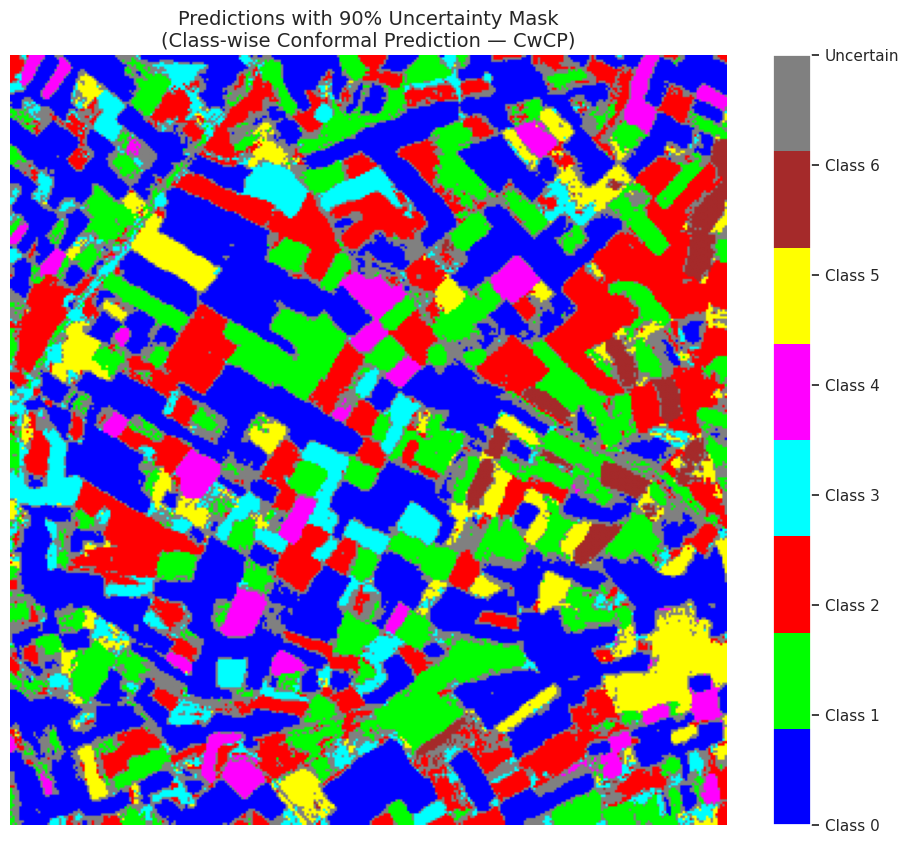

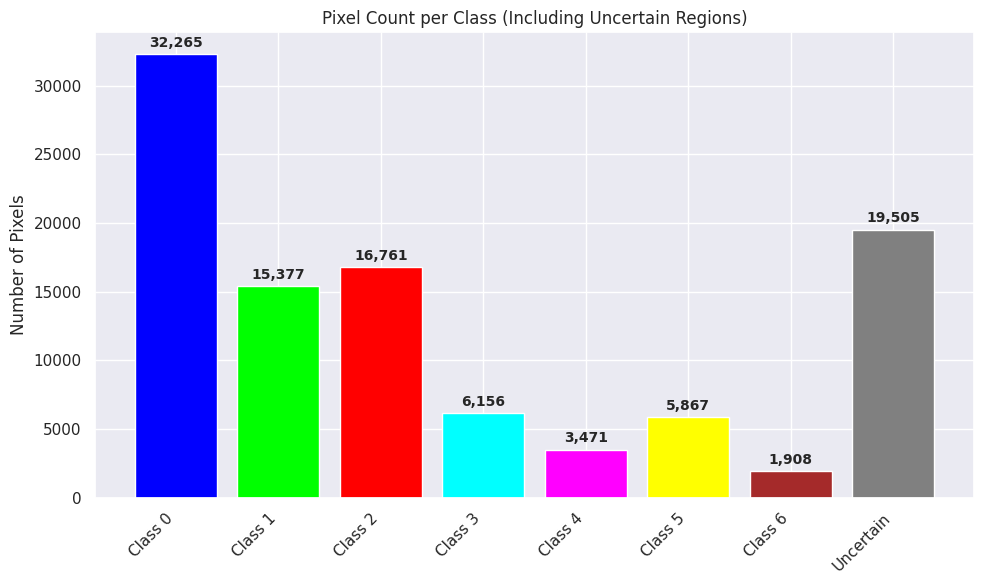

✅ Plots displayed & saved to Excel:
/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/conformal_reports.xlsx


In [ ]:
# -------------------------------------------------------
# 🟧 UNCERTAINTY MAPS VISUALIZATION — Class-wise Conformal Prediction (CwCP)
# -------------------------------------------------------

import os
import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from openpyxl import Workbook, load_workbook
from openpyxl.drawing.image import Image as XLImage

# -------------------------------------------------------
# 🔧 Settings
# -------------------------------------------------------
output_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/"
excel_filename = "conformal_reports.xlsx"
excel_path = os.path.join(output_dir, excel_filename)
os.makedirs(output_dir, exist_ok=True)

# -------------------------------------------------------
# ✅ Use existing predictions & thresholds
# -------------------------------------------------------
num_classes = prob_pred.shape[-1]
q_hats_classwise = np.array(q_hats_classwise).reshape(1, 1, num_classes)

# Compute predictive sets and set sizes (uncertainty measure)
predictive_sets_cw = prob_pred >= (1 - q_hats_classwise)
set_sizes_cw = np.sum(predictive_sets_cw, axis=2)

# Normalize 0‑1 for visualization
norm_set_sizes = (set_sizes_cw - np.min(set_sizes_cw)) / (np.max(set_sizes_cw) - np.min(set_sizes_cw))

# -------------------------------------------------------
# 🎨 1️⃣ Predictive Set Size (Uncertainty Map — reversed color)
# -------------------------------------------------------
fig1 = plt.figure(figsize=(10, 8))
plt.imshow(norm_set_sizes, cmap="viridis")   # reversed viridis
plt.colorbar(label="Predictive set size (Uncertainty)")
plt.title("90% Predictive Set Size (Uncertainty Map)\n(Class-wise Conformal Prediction — CwCP)", fontsize=14)
plt.axis("off")
plt.show()

buf1 = io.BytesIO()
fig1.savefig(buf1, format="png", bbox_inches="tight")
buf1.seek(0)
plt.close(fig1)

# -------------------------------------------------------
# 🎭 2️⃣ Masked Prediction Map with Uncertain Regions
# -------------------------------------------------------
vit_style_colors = [
    "#0000FF", "#00FF00", "#FF0000",
    "#00FFFF", "#FF00FF", "#FFFF00", "#A52A2A"
]
custom_cmap = ListedColormap(vit_style_colors + ["#808080"])  # gray = uncertain

# Mark uncertain pixels (set_size > 1 => uncertain)
combined_map_cw = np.where(set_sizes_cw == 1, pred_class, num_classes)

fig2 = plt.figure(figsize=(12, 10))
plt.imshow(combined_map_cw, cmap=custom_cmap)
plt.title("Predictions with 90% Uncertainty Mask\n(Class-wise Conformal Prediction — CwCP)", fontsize=14)

cbar = plt.colorbar(ticks=np.arange(num_classes + 1))
cbar.set_ticklabels([f"Class {i}" for i in range(num_classes)] + ["Uncertain"])
plt.axis("off")
plt.show()

buf2 = io.BytesIO()
fig2.savefig(buf2, format="png", bbox_inches="tight")
buf2.seek(0)
plt.close(fig2)

# -------------------------------------------------------
# 📊 3️⃣ Bar Chart — Pixel Counts per Class (including Uncertain)
# -------------------------------------------------------
unique_classes, counts = np.unique(combined_map_cw, return_counts=True)
labels = [f"Class {i}" for i in range(num_classes)] + ["Uncertain"]

# Ensure every label index appears
pixel_counts = [counts[unique_classes == i][0] if i in unique_classes else 0
                for i in range(num_classes + 1)]

fig3 = plt.figure(figsize=(10, 6))
bars = plt.bar(labels, pixel_counts, color=list(vit_style_colors) + ['#808080'])

plt.ylabel("Number of Pixels")
plt.xticks(rotation=45, ha="right")
plt.title("Pixel Count per Class (Including Uncertain Regions)")

# Add numeric count above each bar
for bar, count in zip(bars, pixel_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(pixel_counts)*0.01,
             f"{count:,}", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

buf3 = io.BytesIO()
fig3.savefig(buf3, format="png", bbox_inches="tight")
buf3.seek(0)
plt.close(fig3)

# -------------------------------------------------------
# 💾 SAVE FIGURES TO EXCEL
# -------------------------------------------------------
# Create Excel file if missing
if not os.path.exists(excel_path):
    wb = Workbook()
    ws = wb.active
    ws.title = "Info"
    ws["A1"] = "Conformal Prediction Reports"
    ws["A2"] = "Automatically created by script"
    wb.save(excel_path)
    print(f"Created new Excel file at {excel_path}")

# Load and append a new sheet for this run
wb = load_workbook(excel_path)
run_sheet = wb.create_sheet(title=f"CwCP_Run_{len(wb.sheetnames)}")

# Insert images
xl_img1 = XLImage(buf1)
xl_img1.anchor = "A1"
run_sheet.add_image(xl_img1)

xl_img2 = XLImage(buf2)
xl_img2.anchor = "N1"
run_sheet.add_image(xl_img2)

xl_img3 = XLImage(buf3)
xl_img3.anchor = "A25"
run_sheet.add_image(xl_img3)

# Metadata
run_sheet["A48"] = "Saved by CwCP Visualization Script"
run_sheet["A49"] = "Includes Uncertainty Map, Masked Predictions, & Pixel Count Bar Chart"

wb.save(excel_path)
print(f"✅ Plots displayed & saved to Excel:\n{excel_path}")

#**Clustered Conformal Prediction**


=== Clustered Conformal Prediction (ClCP) ===
Calibration set: 2155 | New test set: 2155
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 363ms/step
Feature embedding + softmax generation took 43.08s
Clustered 7 classes → 4 clusters.
Cluster assignments: [2 0 0 0 1 0 3]

--- Clustered CP Results ---
Target Coverage: 0.950
Empirical Coverage: 0.944
Average Set Size: 0.947
Saved coverage plot to Excel sheet 'Clustered Coverage' in
/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/conformal_reports.xlsx


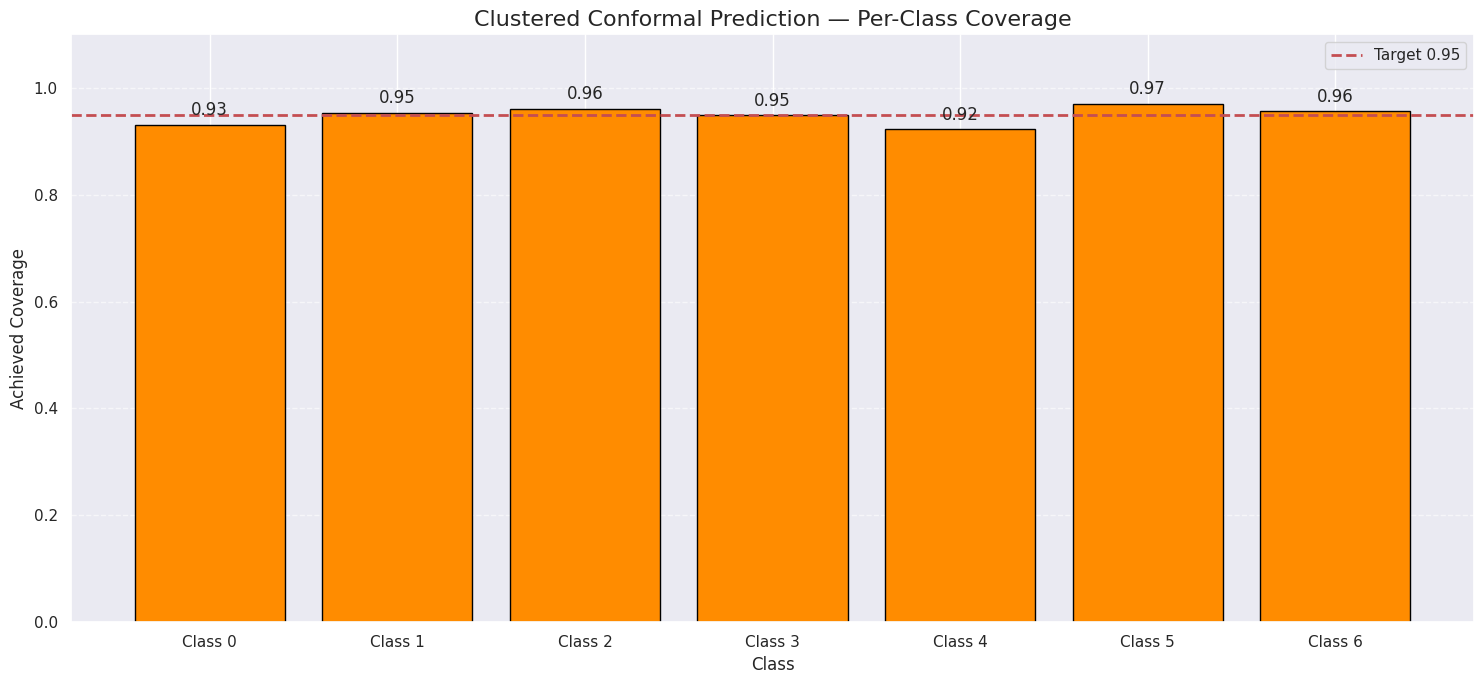

In [ ]:
# -------------------------------------------------------
# 🧠 CLUSTERED CONFORMAL PREDICTION (ClCP) — Compute + Excel Report
# -------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import tensorflow as tf
import time, os, io, openpyxl
from openpyxl.drawing.image import Image as OpenPyXLImage


def clustered_conformal_prediction_keras(
    model, feature_extractor, x_test, y_test,
    alpha=0.05, batch_size=64, n_clusters=4):

    """
    Performs Clustered Conformal Prediction (ClCP) uncertainty analysis for a Keras model.
    Returns cluster assignments and q_hats_per_cluster for visualization.
    """

    print("\n=== Clustered Conformal Prediction (ClCP) ===")

    # 1️⃣ Split test data → calibration + evaluation sets
    x_calib, x_test_new, y_calib, y_test_new = train_test_split(
        np.array(x_test), np.array(y_test),
        test_size=0.5, stratify=y_test, random_state=42
    )
    y_calib, y_test_new = y_calib.reshape(-1), y_test_new.reshape(-1)
    print(f"Calibration set: {len(x_calib)} | New test set: {len(x_test_new)}")

    # 2️⃣ Get probabilities + embeddings
    start = time.time()
    calib_probs = model.predict(x_calib, batch_size=batch_size, verbose=1)
    test_probs  = model.predict(x_test_new, batch_size=batch_size, verbose=1)
    calib_embeds = feature_extractor.predict(x_calib, batch_size=batch_size, verbose=1)
    print(f"Feature embedding + softmax generation took {time.time() - start:.2f}s")

    # 3️⃣ Cluster class representations
    num_classes = calib_probs.shape[1]
    calib_embeds_flat = calib_embeds.reshape(calib_embeds.shape[0], -1)
    mean_embeds_per_class = np.array([
        calib_embeds_flat[y_calib == c].mean(axis=0) if np.any(y_calib == c)
        else np.zeros(calib_embeds_flat.shape[1]) for c in range(num_classes)
    ])

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_assignments = kmeans.fit_predict(mean_embeds_per_class)
    print(f"Clustered {num_classes} classes → {n_clusters} clusters.")
    print("Cluster assignments:", cluster_assignments)

    # 4️⃣ Cluster‑wise calibration
    q_hats_per_cluster = np.zeros(n_clusters)
    for k in range(n_clusters):
        cls_in_cluster = np.where(cluster_assignments == k)[0]
        mask = np.isin(y_calib, cls_in_cluster)
        if mask.sum() == 0:
            q_hats_per_cluster[k] = 1.0
            continue
        scores = 1 - calib_probs[mask, y_calib[mask]]
        n = mask.sum()
        q_level = np.ceil((n + 1) * (1 - alpha)) / n
        q_hats_per_cluster[k] = np.quantile(scores, q_level, method="higher")

    q_hats_clustered = q_hats_per_cluster[cluster_assignments]

    # 5️⃣ Prediction sets & evaluation
    prediction_sets = test_probs >= (1 - q_hats_clustered)
    empirical_cov = prediction_sets[np.arange(len(y_test_new)), y_test_new].mean()
    avg_set_size = prediction_sets.sum(axis=1).mean()

    print(f"\n--- Clustered CP Results ---")
    print(f"Target Coverage: {1-alpha:.3f}")
    print(f"Empirical Coverage: {empirical_cov:.3f}")
    print(f"Average Set Size: {avg_set_size:.3f}")

    # 6️⃣ Per‑class coverage plot
    class_labels = [f"Class {i}" for i in range(num_classes)]
    coverages = []
    for c in range(num_classes):
        mask = (y_test_new == c)
        coverages.append(np.mean(prediction_sets[mask, c]) if mask.sum() else np.nan)

    plt.figure(figsize=(15, 7))
    bars = plt.bar(class_labels, coverages, color="darkorange", edgecolor="black")
    for bar in bars:
        val = bar.get_height()
        if not np.isnan(val):
            plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, f"{val:.2f}",
                     ha='center', va='bottom')
    plt.axhline(1-alpha, color='r', linestyle='--', linewidth=2,
                label=f'Target {1-alpha:.2f}')
    plt.title('Clustered Conformal Prediction — Per-Class Coverage', fontsize=16)
    plt.xlabel('Class'); plt.ylabel('Achieved Coverage')
    plt.ylim(0, 1.1); plt.legend(); plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    # 7️⃣ Save plot into Excel workbook
    output_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/"
    os.makedirs(output_dir, exist_ok=True)
    excel_path = os.path.join(output_dir, "conformal_reports.xlsx")
    sheet_name = "Clustered Coverage"

    try:
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight'); buf.seek(0)
        if os.path.exists(excel_path):
            wb = openpyxl.load_workbook(excel_path)
            if sheet_name in wb.sheetnames:
                del wb[sheet_name]
            sheet = wb.create_sheet(title=sheet_name)
        else:
            wb = openpyxl.Workbook(); sheet = wb.active; sheet.title = sheet_name
        img = OpenPyXLImage(buf)
        sheet.add_image(img, "A1")
        wb.save(excel_path)
        print(f"Saved coverage plot to Excel sheet '{sheet_name}' in\n{excel_path}")
    except Exception as e:
        print(f"⚠️ Excel save failed: {e}")

    plt.show(); plt.close()

    return {
        "coverage": empirical_cov,
        "avg_set_size": avg_set_size,
        "per_class_coverages": np.array(coverages),
        "cluster_assignments": cluster_assignments,
        "q_hats_per_cluster": q_hats_per_cluster
    }


# ✅ Feature extractor (penultimate layer)
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# ✅ Run Clustered CP
results = clustered_conformal_prediction_keras(
    model, feature_extractor, x_test, y_test,
    alpha=0.05, batch_size=64, n_clusters=4
)

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


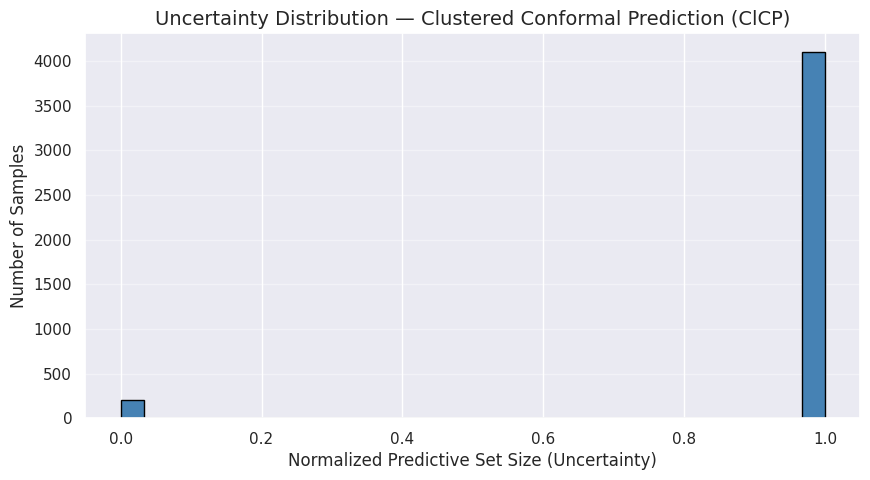

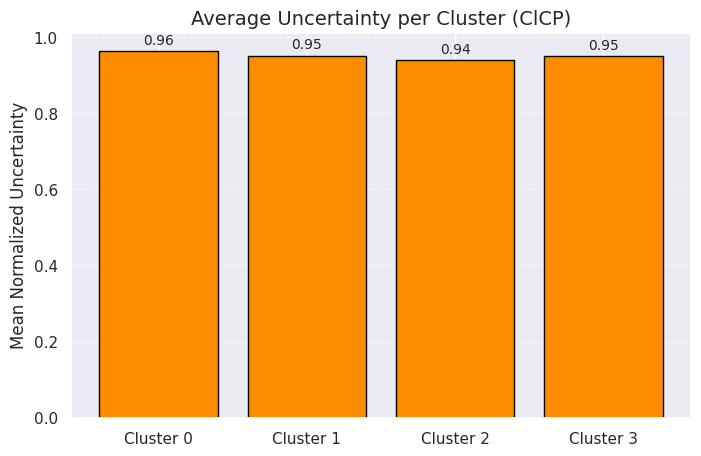

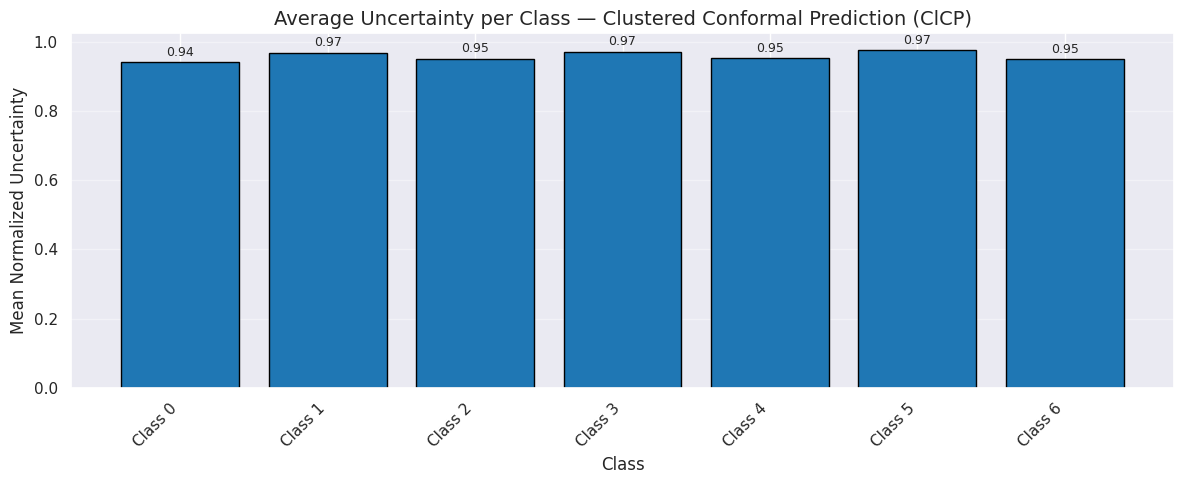

✅ Plots displayed and saved successfully to Excel:
/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/conformal_reports.xlsx


In [ ]:
# -------------------------------------------------------
# 🟧 UNCERTAINTY VISUALIZATION — Clustered Conformal Prediction (ClCP)
# -------------------------------------------------------

import os
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl import Workbook, load_workbook
from openpyxl.drawing.image import Image as XLImage

# -------------------------------------------------------
# 🔧 Save Settings
# -------------------------------------------------------
output_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/"
excel_filename = "conformal_reports.xlsx"
excel_path = os.path.join(output_dir, excel_filename)
os.makedirs(output_dir, exist_ok=True)

# -------------------------------------------------------
# ⚙️ Existing Variables (from your environment)
# -------------------------------------------------------
cluster_assignments = results["cluster_assignments"]          # per-class cluster ID
q_hats_per_cluster = results["q_hats_per_cluster"]
num_classes = len(cluster_assignments)

# Build per-class thresholds
q_per_class = q_hats_per_cluster[cluster_assignments]

# --- Predict on the whole test set ---
prob_pred = model.predict(x_test, batch_size=64, verbose=1)
pred_class = np.argmax(prob_pred, axis=1)

# --- Compute sample-level predictive-set sizes ---
predictive_sets_cl = prob_pred >= (1 - q_per_class)
set_sizes_cl = np.sum(predictive_sets_cl, axis=1)

# --- Normalize predictive-set sizes (0 = certain, 1 = uncertain) ---
norm_uncertainty = (set_sizes_cl - set_sizes_cl.min()) / (set_sizes_cl.max() - set_sizes_cl.min())

# --- Determine cluster ID for each predicted class ---
sample_clusters = np.array(cluster_assignments)[pred_class]

# ===================================================================
# 🎨 1️⃣ Histogram — overall uncertainty distribution
# ===================================================================
fig1 = plt.figure(figsize=(10,5))
plt.hist(norm_uncertainty, bins=30, color='steelblue', edgecolor='black')
plt.xlabel("Normalized Predictive Set Size (Uncertainty)", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("Uncertainty Distribution — Clustered Conformal Prediction (ClCP)", fontsize=14)
plt.grid(axis='y', alpha=0.4)
plt.show()

buf1 = io.BytesIO()
fig1.savefig(buf1, format="png", bbox_inches="tight")
buf1.seek(0)
plt.close(fig1)

# ===================================================================
# 🎨 2️⃣ Average Uncertainty per Cluster
# ===================================================================
df = pd.DataFrame({
    "cluster": sample_clusters,
    "uncertainty": norm_uncertainty
})
cluster_mean_unc = df.groupby("cluster")["uncertainty"].mean().sort_index()

fig2 = plt.figure(figsize=(8,5))
bars = plt.bar([f"Cluster {i}" for i in cluster_mean_unc.index],
               cluster_mean_unc.values, color='darkorange', edgecolor='black')
plt.title("Average Uncertainty per Cluster (ClCP)", fontsize=14)
plt.ylabel("Mean Normalized Uncertainty")
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
             f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=10)
plt.show()

buf2 = io.BytesIO()
fig2.savefig(buf2, format="png", bbox_inches="tight")
buf2.seek(0)
plt.close(fig2)

# ===================================================================
# 🎨 3️⃣ Average Uncertainty per Class
# ===================================================================
class_mean_unc = pd.DataFrame({
    "class": np.arange(num_classes),
    "uncertainty": [norm_uncertainty[pred_class == c].mean() for c in range(num_classes)]
}).dropna()

fig3 = plt.figure(figsize=(12,5))
bars = plt.bar(class_mean_unc["class"], class_mean_unc["uncertainty"],
               color='#1f77b4', edgecolor='black')
plt.xticks(class_mean_unc["class"], [f"Class {c}" for c in class_mean_unc["class"]],
           rotation=45, ha='right')
plt.xlabel("Class")
plt.ylabel("Mean Normalized Uncertainty")
plt.title("Average Uncertainty per Class — Clustered Conformal Prediction (ClCP)", fontsize=14)
plt.grid(axis='y', alpha=0.4)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

buf3 = io.BytesIO()
fig3.savefig(buf3, format="png", bbox_inches="tight")
buf3.seek(0)
plt.close(fig3)


# ===================================================================
# 💾 SAVE FIGURES TO EXCEL
# ===================================================================
# Create Excel if missing
if not os.path.exists(excel_path):
    wb = Workbook()
    ws = wb.active
    ws.title = "Info"
    ws["A1"] = "Conformal Prediction Reports"
    ws["A2"] = "Created via Clustered Conformal Prediction script"
    wb.save(excel_path)
    print(f"Created new Excel file at {excel_path}")

# Load workbook
wb = load_workbook(excel_path)
sheet_name = f"ClCP_Run_{len(wb.sheetnames)}"
ws = wb.create_sheet(title=sheet_name)

# Paste images into Excel sheet
img1 = XLImage(buf1)
img1.anchor = "A1"
ws.add_image(img1)

img2 = XLImage(buf2)
img2.anchor = "N1"
ws.add_image(img2)

img3 = XLImage(buf3)
img3.anchor = "A25"
ws.add_image(img3)

# Metadata
ws["A48"] = "Saved by ClCP Visualization Script"
ws["A49"] = "Includes Uncertainty Histogram, Cluster Averages, Class Averages"

# Save workbook
wb.save(excel_path)
print(f"✅ Plots displayed and saved successfully to Excel:\n{excel_path}")

#**RAPS: Calibration & Prediction**


--- Starting RAPS Conformal Prediction ---
Calibration: 2155 | Evaluation: 2155
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Prediction finished in 0.88s
Running RAPS calibration ...
Target Coverage: 0.95 | Empirical Coverage: 0.989 | Avg Set Size: 1.00
Plot saved ⇒ 'RAPS Coverage' sheet in /content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/conformal_reports.xlsx


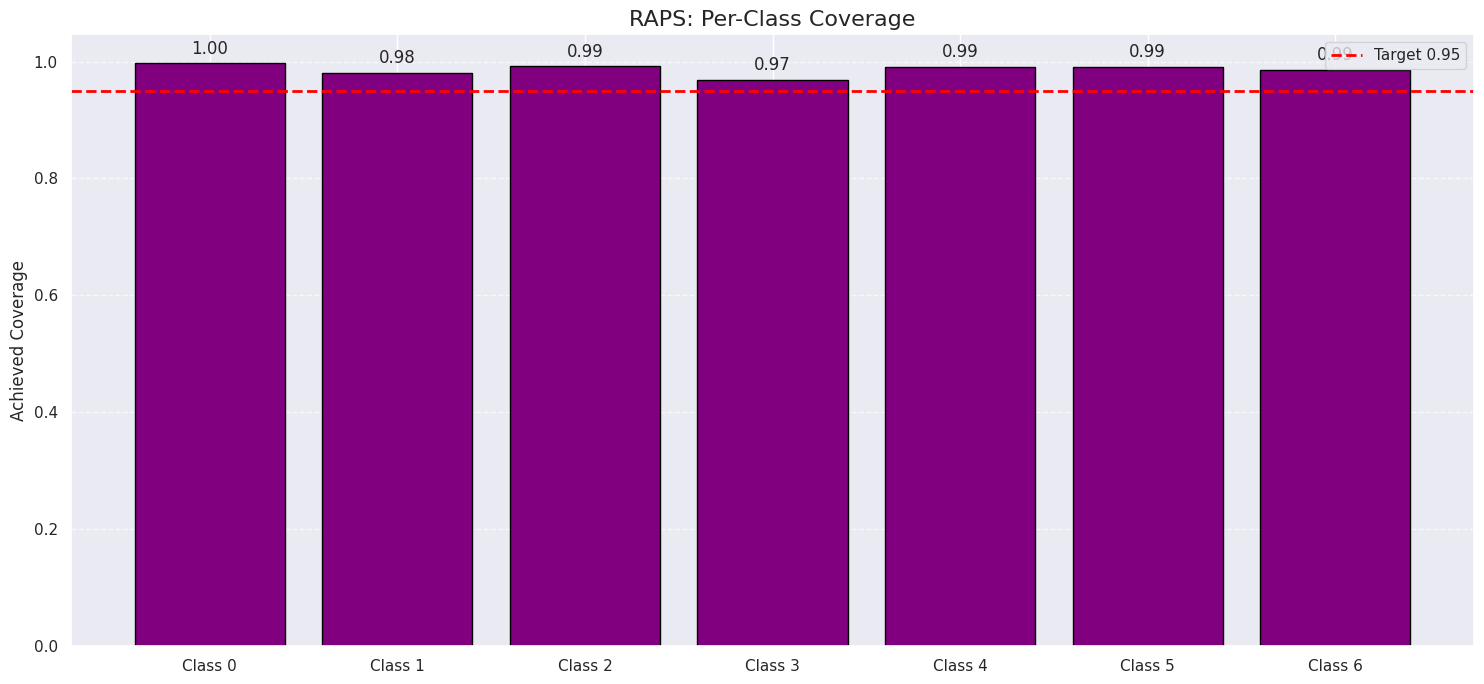

In [ ]:
# -------------------------------------------------------
#  RAPS CONFORMAL PREDICTION (Regularized Adaptive Prediction Sets)
# -------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time, os, io, tensorflow as tf, openpyxl
from openpyxl.drawing.image import Image as OpenPyXLImage

def raps_conformal_prediction_keras(model, x_test, y_test, alpha=0.05, lam=0.01, batch_size=64):
    """
    Regularized Adaptive Prediction Sets (RAPS) for a Keras model.
    Returns prediction_sets_raps and predicted probabilities for uncertainty visualization.
    """
    print("\n--- Starting RAPS Conformal Prediction ---")

    # 1️⃣ Split test set into calibration + evaluation subsets
    x_calib, x_test_new, y_calib, y_test_new = train_test_split(
        np.array(x_test), np.array(y_test),
        test_size=0.5, stratify=y_test, random_state=42
    )
    y_calib, y_test_new = y_calib.reshape(-1), y_test_new.reshape(-1)
    print(f"Calibration: {len(x_calib)} | Evaluation: {len(x_test_new)}")

    # 2️⃣ Model predictions
    start = time.time()
    calib_probs = model.predict(x_calib, batch_size=batch_size, verbose=1)
    test_probs  = model.predict(x_test_new, batch_size=batch_size, verbose=1)
    print(f"Prediction finished in {time.time() - start:.2f}s")

    # 3️⃣ Build RAPS scores
    print("Running RAPS calibration ...")
    n_calib, num_classes = len(y_calib), calib_probs.shape[1]

    calib_probs_sorted = np.sort(calib_probs, axis=1)[:, ::-1]
    calib_ranks = np.argsort(calib_probs, axis=1)[:, ::-1]
    calib_labels_rank = np.array([np.where(calib_ranks[i] == y_calib[i])[0][0] for i in range(n_calib)])
    raps_scores = np.array([
        np.sum(calib_probs_sorted[i, :calib_labels_rank[i]]) + lam * calib_labels_rank[i]
        for i in range(n_calib)
    ])

    # 4️⃣ Quantile threshold
    q_level = np.ceil((n_calib + 1) * (1 - alpha)) / n_calib
    q_hat_raps = np.quantile(raps_scores, q_level, method="higher")

    # 5️⃣ RAPS prediction sets
    test_probs_sorted_indices = np.argsort(test_probs, axis=1)[:, ::-1]
    test_probs_sorted = np.sort(test_probs, axis=1)[:, ::-1]

    prediction_sets_raps = []
    for i in range(len(x_test_new)):
        s, cumulative = [], 0.0
        for k in range(num_classes):
            reg_penalty = lam * k
            if cumulative + reg_penalty <= q_hat_raps:
                s.append(test_probs_sorted_indices[i, k])
                cumulative += test_probs_sorted[i, k]
            else:
                break
        boolean_set = np.zeros(num_classes, dtype=bool)
        if s:
            boolean_set[s] = True
        prediction_sets_raps.append(boolean_set)
    prediction_sets_raps = np.array(prediction_sets_raps)

    # 6️⃣ Metrics
    coverage = prediction_sets_raps[np.arange(len(y_test_new)), y_test_new].mean()
    avg_set_size = prediction_sets_raps.sum(axis=1).mean()
    print(f"Target Coverage: {1-alpha:.2f} | Empirical Coverage: {coverage:.3f} | "
          f"Avg Set Size: {avg_set_size:.2f}")

    # 7️⃣ Per‑class coverage plot
    per_class_coverages = []
    for c in range(num_classes):
        mask = (y_test_new == c)
        if mask.sum() == 0: per_class_coverages.append(np.nan); continue
        per_class_coverages.append(prediction_sets_raps[mask, c].mean())
    per_class_coverages = np.array(per_class_coverages)

    plt.figure(figsize=(15,7))
    bars = plt.bar([f"Class {i}" for i in range(num_classes)],
                   per_class_coverages, color='purple', edgecolor='black')
    for bar in bars:
        yv = bar.get_height()
        if not np.isnan(yv):
            plt.text(bar.get_x()+bar.get_width()/2, yv+0.01, f"{yv:.2f}",
                     ha='center', va='bottom')
    plt.axhline(y=1-alpha, color='red', ls='--', lw=2,
                label=f'Target {1-alpha:.2f}')
    plt.title('RAPS: Per-Class Coverage', fontsize=16)
    plt.ylabel('Achieved Coverage')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.legend()

    # 8️⃣ Save to Excel
    out_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/Vision Transformers/6 bands/ClassWiseCP/"
    os.makedirs(out_dir, exist_ok=True)
    excel_fp = os.path.join(out_dir, "conformal_reports.xlsx")
    sheet = "RAPS Coverage"
    try:
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight'); buf.seek(0)
        if os.path.exists(excel_fp):
            wb = openpyxl.load_workbook(excel_fp)
            if sheet in wb.sheetnames:
                del wb[sheet]
            ws = wb.create_sheet(title=sheet)
        else:
            wb = openpyxl.Workbook(); ws = wb.active; ws.title = sheet
        img = OpenPyXLImage(buf); ws.add_image(img, 'A1')
        wb.save(excel_fp)
        print(f"Plot saved ⇒ '{sheet}' sheet in {excel_fp}")
    except Exception as e:
        print(f"⚠️ Excel save failed: {e}")
    plt.show(); plt.close()

    return {
        "coverage": coverage,
        "avg_set_size": avg_set_size,
        "per_class_coverages": per_class_coverages,
        "prediction_sets_raps": prediction_sets_raps,
        "y_test_new": y_test_new,
        "num_classes": num_classes
    }

# ✅ Run RAPS
results = raps_conformal_prediction_keras(model, x_test, y_test, alpha=0.05, lam=0.01, batch_size=64)